In [3]:
# Llamado de librerias
library(dplyr)
library(ggplot2)
library(patchwork)
library(forecast)
library(tseries)
library(scales)
library(gridExtra)
library(reshape)
library(matlib)

In [53]:
# Importando archivo .csv
File = read.csv(file = ('../Ejercicio inflación/DESEMPLEO.csv'), skip = 0, header = TRUE)
head(File)
sprintf('El número de observaciones son: %s', length(File[, 1]))

,TIEMPO,Inflacion,Atipicos
,<chr>,<dbl>,<int>
1,1/31/2001,16.62,0
2,2/28/2001,17.43,0
3,3/31/2001,15.81,0
4,4/30/2001,14.52,0
5,5/31/2001,14.04,0
6,6/30/2001,15.31,0


[1] "El número de observaciones son: 252"

## Inputs

In [54]:
# Inputs 
K = T / 4                                       # 'Truncado' para (T / 4), si no ingrese el valor numérico
alpha = 0.05                                    # Nivel de significancia

# Desestacionalización
k = 12                                          # Coeficiente de medias moviles y estacionalidad

# Estabilización de la varianza
R = 12                                          # Total de observaciones por grupo o división
Lambdas = c(-2, -1, -0.5, 0, 0.5, 1, 2)                # Vector de Lambdas c(2, 1, 0.5, 0, -0.5, -1, -2)   

# Esabilización de nivel
K.Dif = 3                                       # Diferenciación de la estabilización de nivel, normalmente no se requiere diferenciaciones (rezago) de grado más alto

# Parámetros y transformaciones lineales
X = File$Inflacion

# Datos a pronosticar
P = 24

## Variables y condicionales

,K,X
,<date>,<dbl>
1,2001-01-31,16.62
2,2001-02-28,17.43
3,2001-03-31,15.81
4,2001-04-30,14.52
5,2001-05-31,14.04
6,2001-06-30,15.31


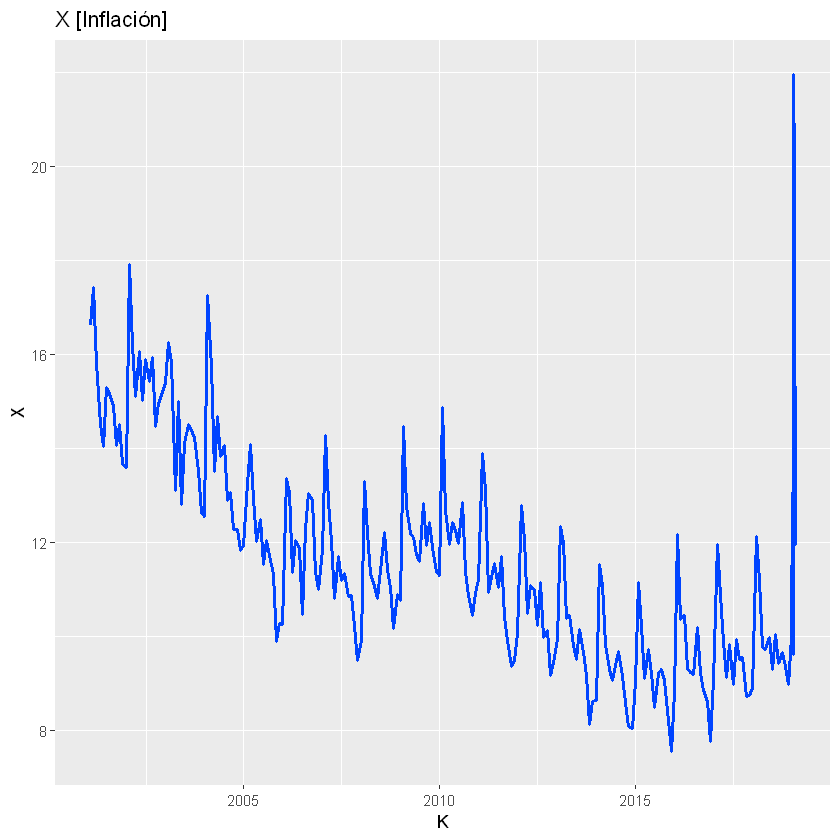

In [56]:
# Construcción de los vectores y parámetros
X = cbind(X)
T = length(X)

# Condición de K
if (K == 'Truncado'){
    K = length(File[, 1]) / 4
} else {
    K = K
}

# Función para verificar si un número es entero o no
is.wholenumber <- function(x, tol = .Machine$double.eps ** 0.5)abs(x - round(x)) < tol             # TRUE = Entero, FALSE = Decimal

# Redefinición de los datos
X.r = matrix(data = X, nrow = k)
if (is.wholenumber(T / R) == 'FALSE'){
  H = floor(T / R)
  if (T > (H * R)){                                     # Llenar de NA los datos que se repiten al no ser múltiplo de R la matriz
    l = T - (H * R)
    X.r[((l + 1) : R), (H + 1)] = NA
  }
} else if (is.wholenumber(T / R) == 'TRUE'){
  H = T / R
  X.r = matrix(data = X, nrow = k)
}

# Fechas
Dates = as.matrix(File[, 1])
Dates1 = as.Date(Dates, '%m/%d/%Y')


# Gráfica de los datos
XI = data.frame(matrix(data = NA, nrow = K, ncol = 2))  
colnames(XI) = c('K', 'X')
XI[, 1] = Dates1[1 : K]
XI[, 2] = X[1 : K]
XI = with(XI, data.frame(K, X))

G_X <- ggplot(data = XI, mapping = aes(x = K, y = X)) +
  geom_line(colour = '#0044ff', size = 1) +
  labs(title = 'X [Inflación]')
        
# Salidas 
head(XI)
G_X

## DGP's

### DGP[1]

In [75]:
DGP.1 = function(Phi, Mu, Sigma_a = 1, T, Zt_0, N_scenarios = 20, N_remove = 0){
    DGP.1 = matrix(data = NA, nrow = T, ncol = N_scenarios)
    DGP.1[1, ] = Zt_0
    for (j in 1 : N_scenarios){
        set.seed(j)
        At = rnorm(n = T, mean = 0, sd = Sigma_a)
        for (i in 2 : T){
            DGP.1[i, j] = Mu + Phi * DGP.1[i - 1, j] + At[i]
        }
        # DGP.1[, j] = DGP.1[, j] - mean(DGP.1[, j])
    }
    if (N_remove == 0){
        Zt.1 = DGP.1
    } else {
        Zt.1 = DGP.1[-(1 : N_remove), ]
    }
    Zt.1 = data.frame(Zt.1)

    # Salidas
    return(head(Zt.1))
}

DGP.1(Phi = 0.36, Mu = 1, Sigma_a = 0.15, T = 240, Zt_0 = 1, N_scenarios = 100)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,⋯,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.387546,1.387727,1.316121,1.278626,1.567654,1.265502,1.180484,1.486060,1.237531,1.332362,⋯,1.363228,1.285375,1.259774,1.411939,1.117671,1.571297,1.669895,1.294685,1.431949,1.379730
3,1.374172,1.737759,1.512622,1.593977,1.376032,1.585880,1.320830,1.465459,1.424281,1.273951,⋯,1.767344,1.602285,1.561649,1.282432,1.398180,1.842975,1.747851,1.363804,1.528676,1.484865
4,1.733994,1.456037,1.371724,1.663229,1.505893,1.829996,1.413655,1.444940,1.471100,1.368747,⋯,2.006885,1.398589,1.701979,1.649879,1.455176,1.867358,1.902643,1.206051,1.616902,1.667569
5,1.673664,1.512135,1.523188,1.844105,1.798838,1.662427,1.363315,1.630584,1.595042,1.536931,⋯,1.586422,1.241696,1.738729,1.410331,1.805919,1.651094,1.604284,1.521571,1.527659,1.617871
6,1.479449,1.564232,1.552866,1.767269,1.557145,1.653677,1.348701,1.570828,1.396184,1.611764,⋯,1.876076,1.299775,1.451916,1.487206,1.754652,1.384825,1.574082,1.709366,1.568358,1.630228


### DGP[2]

In [74]:
DGP.2 = function(Phi, Mu, Beta, Sigma_a = 1, T, Zt_0, N_scenarios = 20, N_remove = 0, K.Dif = 3){
    DGP.2 = matrix(data = NA, nrow = T, ncol = N_scenarios)
    DGP.2[1, ] = Zt_0
    t = c(1 : (T - 1))
    for (j in 1 : N_scenarios){
        set.seed(j)
        At = rnorm(n = T, mean = 0, sd = Sigma_a)
        for (i in 2 : T){
            DGP.2[i, j] = Mu + Beta * i + Phi * DGP.2[i - 1, j] + At[i]
        }
        # DGP.2[, j] = DGP.2[, j] - mean(DGP.2[, j])
    }
    if (N_remove == 0){
        Zt.2 = DGP.2
    } else {
        Zt.2 = DGP.2[-(1 : N_remove), ]
    }
    Zt.2 = data.frame(Zt.2)

    # Estabilización en nivel
    Est.Nivel = function(Data, K.Dif){
        X = Data
        # Operador de diferencia
        Diferencia = function(Data, K.Dif){                                 # Operador de diferencia
            Serie.dif = matrix(data = NA, nrow = (T - K.Dif), ncol = 1)
            for(i in 1: (T - K.Dif)){
                Serie.dif[i] <- Data[i + K.Dif] - Data[i]
            }
            return(Serie.dif)
        }

        # Matrix con los datos de J
        S = matrix(data = NA, nrow = (K.Dif + 1), ncol = 2)
        colnames(S) = c('J', 'S(J)')
        S[, 1] = seq(0, K.Dif, 1)
        for (i in 1 : K.Dif){
            # Diferenciación de la serie
            X.dif = matrix(data = NA, ncol = 1, nrow = (T - i))
            X.dif[, 1] = Diferencia(Data = X, K.Dif = i)

            # Cálculo de los S(j) diferenciadores (rezagados)
            S[1, 2] = round(sqrt((1 / (T - 0 - 1)) * sum((X - sum(X / (T - 0))) ** 2)), 6)                            # Diferenciación de J = 0
            S[(i + 1), 2] = round(sqrt((1 / (T - i - 1)) * sum((X.dif - sum(X.dif / (T - i))) ** 2)), 6)
        }

        # J óptimo (mínimo)
        Opt = which.min(S[, 2])                     # Número en que posición esta el mínimo 
        J_opt = S[Opt, 1]                           # Número de diferencias aplicadas a la serie

        # La transformación aplicada a los datos
        X = Diferencia(Data = X, K.Dif = J_opt)
    }
    
    Nt = length(Est.Nivel(Data = Zt.2[, 1], K.Dif = K.Dif) )
    Zt.f = matrix(data = NA, nrow = Nt, ncol = N_scenarios)
    for (i in 1 : N_scenarios){
        Zt.f[, i] = Est.Nivel(Data = Zt.2[, i], K.Dif = K.Dif) 
    }
    Zt.f = data.frame(Zt.f)

    # Salidas
    # print(head(Zt.2))
    return(head(Zt.f))
}

DGP.2(Phi = 0.36, Mu = 1, Beta = 0.5, Sigma_a = 0.15, T = 240, N_scenarios = 100, Zt_0 = 0)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2.0275465,2.0277274,1.9561211,1.9186261,2.2076539,1.9055022,1.8204842,2.1260600,1.8775312,1.9723621,⋯,2.0032283,1.9253749,1.8997744,2.0519391,1.7576711,2.2112967,2.3098950,1.9346853,2.0719487,2.0197297
2,1.0770259,1.4404313,1.2869007,1.4057510,0.8987777,1.4107776,1.2307462,1.0697992,1.2771497,1.0319887,⋯,1.4945153,1.4073097,1.3922748,0.9608929,1.3709086,1.3620780,1.1683561,1.1595189,1.1871271,1.1955354
3,1.2523658,0.6108221,0.7516462,0.9617957,1.0224052,1.1366603,0.9853686,0.8720249,0.9393634,0.9873403,⋯,1.1320858,0.6888480,1.0328734,1.2599913,0.9495399,0.9169275,1.0473360,0.7347906,0.9807702,1.0752480
4,0.7609857,0.8774145,0.9727799,1.0021921,1.1142606,0.6537465,0.7709756,1.0069603,0.9452576,0.9894994,⋯,0.4008519,0.6644235,0.8580666,0.5817673,1.1720592,0.6050520,0.5229568,1.1368356,0.7320728,0.7716173
5,0.6014584,0.8477700,0.8253519,0.7188378,0.5539815,0.7869244,0.7810602,0.7359174,0.5968158,0.8705072,⋯,1.0853279,0.8537519,0.5088600,0.8725491,0.7444066,0.5294041,0.7654719,0.9834691,0.8363730,0.8080310
6,0.9127097,0.8915274,0.8054208,0.4632033,0.7190446,0.5317084,1.0354946,0.7555691,1.0716826,0.5737020,⋯,0.6184101,1.1673382,1.2643300,0.7744246,0.5337338,1.1937451,0.7946756,0.5850285,0.6531164,0.6558281


### DGP[3]

In [76]:
DGP.3 = function(Sigma_a = 1, T, Zt_0, N_scenarios = 20, N_remove = 0){
    DGP.3 = matrix(data = NA, nrow = T, ncol = N_scenarios)
    DGP.3[1, ] = Zt_0
    for (j in 1 : N_scenarios){
        set.seed(j)
        At = rnorm(n = T, mean = 0, sd = Sigma_a)
        for (i in 2 : T){
            DGP.3[i, j] = DGP.3[i - 1, j] + At[i]
        }
        # DGP.3[, j] = DGP.3[, j] - mean(DGP.3[, j])
    }
    if (N_remove == 0){
        Zt.3 = DGP.3
    } else {
        Zt.3 = DGP.3[-(1 : N_remove), ]
    }
    Zt.3 = data.frame(Zt.3)

    # Estabilización en varianza
    Est.Var = function(Data, R = 12, Lambdas = c(-1, -0.5, 0, 0.5, 1)){
        X = Data
        T = length(X)

        # Función para verificar si un número es entero o no
        is.wholenumber <- function(x, tol = .Machine$double.eps ** 0.5)abs(x - round(x)) < tol             # TRUE = Entero, FALSE = Decimal

        # Redefinición de los datos
        X.r = matrix(data = X, nrow = 12)
        if (is.wholenumber(T / R) == 'FALSE'){
            H = floor(T / R)
            if (T > (H * R)){                                     # Llenar de NA los datos que se repiten al no ser múltiplo de R la matriz
                l = T - (H * R)
                X.r[((l + 1) : R), (H + 1)] = NA
            }
        } else if (is.wholenumber(T / R) == 'TRUE'){
            H = T / R
            X.r = matrix(data = X, nrow = R)
        }

        # Cálculo de las medias y desviaciones
        Zb = matrix(data = NA, ncol = H, nrow = 1)
        Zvar = matrix(data = NA, ncol = H, nrow = 1)
        for (i in 1 : H){
        Zb[i] = sum(X.r[, i]) / R
        Zvar[i] = sqrt((sum((X.r[, i] - Zb[i]) ** 2)) / (R - 1))
        }

        # Crear vector de lambdas
        Nlambdas = length(Lambdas)

        # Datos transformados
        Data.t = matrix(data = NA, ncol = Nlambdas, nrow = H)
        for (i in 1 : Nlambdas){
            for (j in 1 : H){
                Data.t[j, i] = Zvar[j] / (Zb[j] ** (1 - Lambdas[i])) 
            }
        }

        # Matriz con los datos de los lambas
        MLambda = matrix(data = NA, nrow = Nlambdas, ncol = 4)
        colnames(MLambda) = c("Lambda", "M (Lambda)","SD (Lambda)","CV (Lambda)")
        MLambda[, 1] = Lambdas

        for (i in 1 : Nlambdas){
        MLambda[i, 2] = mean(Data.t[, i])
        MLambda[i, 3] = sqrt((sum((Data.t[, i] - MLambda[i, 2]) ** 2)) / (H - 1))
        MLambda[i, 4] = MLambda[i, 3] / MLambda[i, 2]
        }

        # Lambda óptimo (mínimo)
        Opt = which.min(MLambda[, 4])                     # Número en que posición esta el mínimo 
        Lambda_opt = Lambdas[Opt]                         # Lambda óptimo

        # La transformación aplicada a los datos
        if (Lambda_opt == 0){
            X = log(X)
        } else {
            X = X ** Lambda_opt
        }
        # print(Lambda_opt)
    }

    Nt = length(Est.Var(Data = Zt.3[, 1]))
    Zt.f = matrix(data = NA, nrow = Nt, ncol = N_scenarios)
    for (i in 1 : N_scenarios){
        Zt.f[, i] = Est.Var(Data = Zt.3[, i]) 
    }
    Zt.f = data.frame(Zt.f)

    # Salidas
    # print(head(Zt.3))
    return(head(Zt.f))
}

DGP.3(Sigma_a = 0.11, T = 240, Zt_0 = 20, N_scenarios = 100)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20.00000,2.995732,20.00000,20.00000,20.00000,0.05000000,20.00000,2.995732,20.00000,20.00000,⋯,2.995732,0.05000000,2.995732,20.00000,20.00000,20.00000,20.00000,20.00000,2.995732,0.05000000
2,20.02020,2.996748,19.96782,19.94033,20.15228,0.05017385,19.86836,3.000344,19.91019,19.97973,⋯,2.995851,0.05013719,2.992051,20.03809,19.82229,20.15495,20.22726,19.95210,2.998367,0.04996386
3,19.92828,3.005435,19.99629,20.03835,20.01418,0.04993445,19.79198,2.997803,19.89462,19.82889,⋯,3.005940,0.04988125,2.996022,19.87245,19.81923,20.35831,20.33483,19.87710,2.998849,0.04998554
4,20.10376,2.999259,19.86955,20.10391,20.02189,0.04946517,19.74663,2.994775,19.86408,19.76298,⋯,3.019302,0.05020860,3.001133,20.01047,19.78390,20.50783,20.53533,19.66815,3.001279,0.04974299
5,20.14001,2.998819,19.89109,20.28383,20.21015,0.04945866,19.63986,2.998819,19.91208,19.79538,⋯,3.014418,0.05069728,3.005718,19.87581,19.99074,20.49231,20.47618,19.73224,2.999293,0.04971118
6,20.04976,2.999545,19.89440,20.35965,20.14383,0.04935983,19.53566,2.998227,19.78152,19.83825,⋯,3.025333,0.05097632,2.999381,19.86077,20.06739,20.33863,20.47364,19.85075,2.999965,0.04962471


### DGP[4]

In [77]:
DGP.4 = function(Mu, Sigma_a = 1, T, Zt_0, N_scenarios = 20, N_remove = 0, K.Dif = 3){
    DGP.4 = matrix(data = NA, nrow = T, ncol = N_scenarios)
    DGP.4[1, ] = Zt_0
    for (j in 1 : N_scenarios){
        set.seed(j)
        At = rnorm(n = T, mean = 0, sd = Sigma_a)
        for (i in 2 : T){
            DGP.4[i, j] = Mu + DGP.4[i - 1, j] + At[i]
        }
        # DGP.4[, j] = DGP.4[, j] - mean(DGP.4[, j])
    }
    if (N_remove == 0){
        Zt.4 = DGP.4
    } else {
        Zt.4 = DGP.4[-(1 : N_remove), ]
    }
    Zt.4 = data.frame(Zt.4)

    # Estabilización en varianza
    Est.Var = function(Data, R = 12, Lambdas = c(-1, -0.5, 0, 0.5, 1)){
        X = Data
        T = length(X)

        # Función para verificar si un número es entero o no
        is.wholenumber <- function(x, tol = .Machine$double.eps ** 0.5)abs(x - round(x)) < tol             # TRUE = Entero, FALSE = Decimal

        # Redefinición de los datos
        X.r = matrix(data = X, nrow = 12)
        if (is.wholenumber(T / R) == 'FALSE'){
            H = floor(T / R)
            if (T > (H * R)){                                     # Llenar de NA los datos que se repiten al no ser múltiplo de R la matriz
                l = T - (H * R)
                X.r[((l + 1) : R), (H + 1)] = NA
            }
        } else if (is.wholenumber(T / R) == 'TRUE'){
            H = T / R
            X.r = matrix(data = X, nrow = R)
        }

        # Cálculo de las medias y desviaciones
        Zb = matrix(data = NA, ncol = H, nrow = 1)
        Zvar = matrix(data = NA, ncol = H, nrow = 1)
        for (i in 1 : H){
        Zb[i] = sum(X.r[, i]) / R
        Zvar[i] = sqrt((sum((X.r[, i] - Zb[i]) ** 2)) / (R - 1))
        }

        # Crear vector de lambdas
        Nlambdas = length(Lambdas)

        # Datos transformados
        Data.t = matrix(data = NA, ncol = Nlambdas, nrow = H)
        for (i in 1 : Nlambdas){
            for (j in 1 : H){
                Data.t[j, i] = Zvar[j] / (Zb[j] ** (1 - Lambdas[i])) 
            }
        }

        # Matriz con los datos de los lambas
        MLambda = matrix(data = NA, nrow = Nlambdas, ncol = 4)
        colnames(MLambda) = c("Lambda", "M (Lambda)","SD (Lambda)","CV (Lambda)")
        MLambda[, 1] = Lambdas

        for (i in 1 : Nlambdas){
        MLambda[i, 2] = mean(Data.t[, i])
        MLambda[i, 3] = sqrt((sum((Data.t[, i] - MLambda[i, 2]) ** 2)) / (H - 1))
        MLambda[i, 4] = MLambda[i, 3] / MLambda[i, 2]
        }

        # Lambda óptimo (mínimo)
        Opt = which.min(MLambda[, 4])                     # Número en que posición esta el mínimo 
        Lambda_opt = Lambdas[Opt]                         # Lambda óptimo

        # La transformación aplicada a los datos
        if (Lambda_opt == 0){
            X = log(X)
        } else {
            X = X ** Lambda_opt
        }
        # print(Lambda_opt)
    }

    Nt = length(Est.Var(Data = Zt.4[, 1]))
    Zt.v = matrix(data = NA, nrow = Nt, ncol = N_scenarios)
    for (i in 1 : N_scenarios){
        Zt.v[, i] = Est.Var(Data = Zt.4[, i]) 
    }
    Zt.v = data.frame(Zt.v)

    # Estabilización en nivel
    Est.Nivel = function(Data, K.Dif){
        X = Data
        T = length(X)
        # Operador de diferencia
        Diferencia = function(Data, K.Dif){                                 # Operador de diferencia
            Serie.dif = matrix(data = NA, nrow = (T - K.Dif), ncol = 1)
            for(i in 1: (T - K.Dif)){
                Serie.dif[i] <- Data[i + K.Dif] - Data[i]
            }
            return(Serie.dif)
        }

        # Matrix con los datos de J
        S = matrix(data = NA, nrow = (K.Dif + 1), ncol = 2)
        colnames(S) = c('J', 'S(J)')
        S[, 1] = seq(0, K.Dif, 1)
        for (i in 1 : K.Dif){
            # Diferenciación de la serie
            X.dif = matrix(data = NA, ncol = 1, nrow = (T - i))
            X.dif[, 1] = Diferencia(Data = X, K.Dif = i)

            # Cálculo de los S(j) diferenciadores (rezagados)
            S[1, 2] = round(sqrt((1 / (T - 0 - 1)) * sum((X - sum(X / (T - 0))) ** 2)), 6)                            # Diferenciación de J = 0
            S[(i + 1), 2] = round(sqrt((1 / (T - i - 1)) * sum((X.dif - sum(X.dif / (T - i))) ** 2)), 6)
        }

        # J óptimo (mínimo)
        Opt = which.min(S[, 2])                     # Número en que posición esta el mínimo 
        J_opt = S[Opt, 1]                           # Número de diferencias aplicadas a la serie

        # La transformación aplicada a los datos
        X = Diferencia(Data = X, K.Dif = J_opt)
    }
    
    Nt = length(Est.Nivel(Data = Zt.v[, 1], K.Dif = K.Dif))
    Zt.f = matrix(data = NA, nrow = Nt, ncol = N_scenarios)
    for (i in 1 : N_scenarios){
        Zt.f[, i] = Est.Nivel(Data = Zt.v[, i], K.Dif = K.Dif) 
    }
    Zt.f = data.frame(Zt.f)

    # Salidas 
    return(head(Zt.f))
}

DGP.4(Mu = 1, Sigma_a = 0.15, T = 240, Zt_0 = 0, N_scenarios = 100)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.0275465,1.0277274,0.9561211,0.9186261,1.2076539,0.9055022,0.8204842,1.1260600,0.8775312,0.9723621,⋯,1.0032283,0.9253749,0.8997744,1.0519391,0.7576711,1.2112967,1.3098950,0.9346853,1.0719487,1.0197297
2,0.8746557,1.2381768,1.0388182,1.1336717,0.8116762,1.1302990,0.8958561,0.9304776,0.9787697,0.7943004,⋯,1.2765814,1.1395497,1.1081304,0.7741339,0.9958181,1.2773078,1.1466889,0.8977175,1.0131743,0.9881624
3,1.2392921,0.8304436,0.8271802,1.0893971,1.0105214,1.2590793,0.9381561,0.9173747,0.9583592,0.9101248,⋯,1.3706417,0.8217662,1.1397849,1.1882038,0.9518309,1.2038873,1.2734167,0.7150813,1.0665788,1.1330177
4,1.0494262,0.9879622,1.0293674,1.2453427,1.2567161,1.0036281,0.8543990,1.1104061,1.0654460,1.0441818,⋯,0.8639428,0.7382044,1.1260171,0.8163742,1.2820557,0.9788454,0.9193326,1.0873922,0.9455743,1.0175457
5,0.8769297,1.0198630,1.0045186,1.1033913,0.9095638,1.0552038,0.8579080,0.9838178,0.8219691,1.0584691,⋯,1.3049639,0.8527638,0.8259731,0.9794871,1.1045210,0.7904308,0.9965400,1.1616005,1.0184011,1.0477945
6,1.0731144,1.1061932,1.0128127,0.8078130,0.9291750,0.8036194,1.1122209,0.9744566,1.1787980,0.8187886,⋯,1.0326560,1.2127514,1.4071135,0.9397941,0.8702684,1.2935904,1.0156457,0.8925801,0.8704232,0.9127314


## Desestacionalización de la serie
- **Tendencia:** Es un patrón a largo plazo, relativamente suave, exhibido por la serie a través del tiempo. Este se caracteriza por su patrón gradual y consistente que presenta variaciones propias de la serie lo cual es producto de las fuerzas persistentes que afectan el crecimiento o la reducción.
- **Estacionalidad:** Es un patrón de la serie que exhibe a intervalos regulares de tiempo dentro del año. Esta asociado con estaciones o movimientos que se dan en los mismos meses año tras año.
- **Componente aleatorio:** Es el componente resultante de extraer de la serie de tiempo, los 3 componentes anteriores. Estos son factores de corto plazo, imprevisible y no recurrentes que afectan a la serie de tiempo.
- **Serie de tiempo:** Conjunto de variables aleatorias indexadas a través del tiempo que miden el mismo fenómeno macroeconómico.

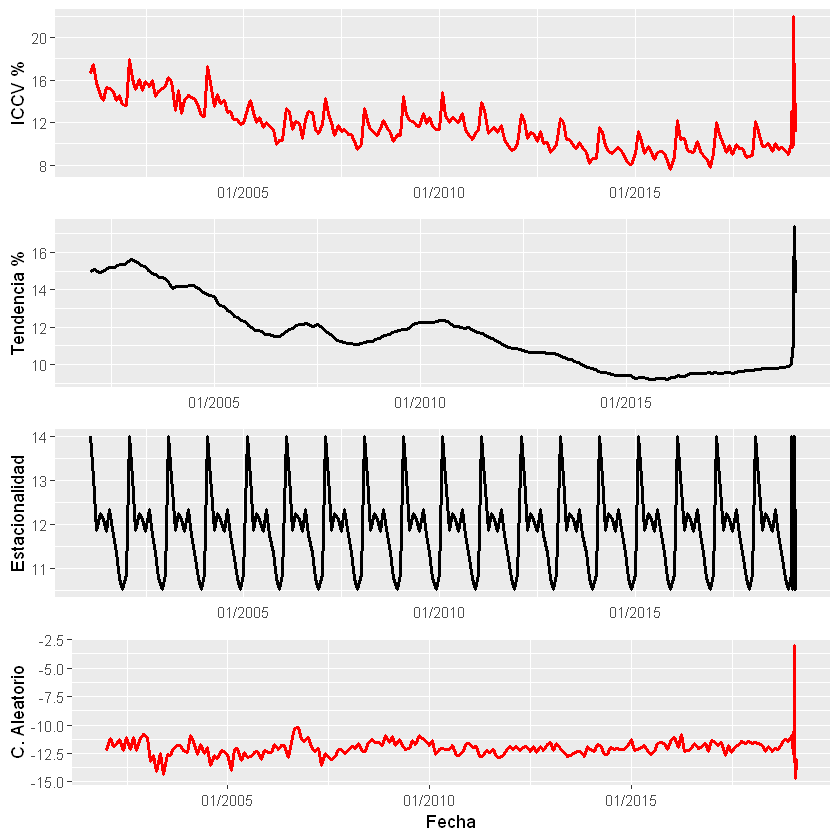

In [31]:
# Cálculo de la tendencia 
Tendencia <- matrix(data = NA, ncol = 1, nrow = T)
for(i in k : T){
  Tendencia[i] <- mean(X[(i - k + 1) : i])
}

# Cálculo del componente estacional 
Xt = X - Tendencia
Estacional1y <- matrix(data = NA, ncol = 1, nrow = k)
for(i in 1 : k){
  Estacional1y[i] = mean(X[seq(from = i, to = floor(T / k) * k, by = k)])
}
Estac_1y <- matrix(data = Estacional1y, ncol = 1, nrow = T)

# Cálculo del componente aleatorio
C_Aleatorio = Xt - Estac_1y

# Salidas gráficas
XTs = data.frame(matrix(data = NA, nrow = length(X), ncol = 2))           # Datos del archivo
colnames(XTs) = c('K', 'X')
XTs[, 1] = Dates1[1 : length(X)]
XTs[, 2] = X

G_XTs <- ggplot(data = XTs, mapping = aes(x = K, y = X)) +
  geom_line(colour = 'red', size = 1) +
  labs(x = 'Fecha', y = 'ICCV %') +
  scale_x_date(labels = date_format("%m/%Y")) +
  theme(axis.title.x=element_blank(),
        axis.ticks.x=element_blank())

XT = data.frame(matrix(data = NA, nrow = (length(X) - (k - 1)), ncol = 2))           # Datos de la tendencia
colnames(XT) = c('K', 'X')
XT[, 1] = Dates1[k : length(X)]
XT[, 2] = Tendencia[k : length(X)]


G_XT <- ggplot(data = XT, mapping = aes(x = K, y = X)) +
  geom_line(colour = 'black', size = 1) +
  labs(x = 'Fecha', y = 'Tendencia %') +
  scale_x_date(labels = date_format("%m/%Y")) +
  theme(axis.title.x=element_blank(),
        axis.ticks.x=element_blank())

XSt = data.frame(matrix(data = NA, nrow = length(Estac_1y), ncol = 2))           # Datos de la estacionalidad
colnames(XSt) = c('K', 'X')
XSt[, 1] = Dates1[1 : length(Estac_1y)]
XSt[, 2] = Estac_1y[1 : length(Estac_1y)]


G_XSt <- ggplot(data = XSt, mapping = aes(x = K, y = X)) +
  geom_line(colour = 'black', size = 1) +
  labs(x = 'Fecha', y = 'Estacionalidad') +
  scale_x_date(labels = date_format("%m/%Y")) +
  theme(axis.title.x=element_blank(),
        axis.ticks.x=element_blank())

X_Ca = data.frame(matrix(data = NA, nrow = (length(C_Aleatorio) - (k - 1)), ncol = 2))                   # Datos componente aleatorio
colnames(X_Ca) = c('K', 'X')
X_Ca[, 1] = Dates1[12 : length(C_Aleatorio)]
X_Ca[, 2] = C_Aleatorio[12 : length(C_Aleatorio)]

G_XCa <- ggplot(data = X_Ca, mapping = aes(x = K, y = X)) +
  geom_line(colour = 'red', size = 1) +
  labs(x = 'Fecha', y = 'C. Aleatorio') +
  scale_x_date(labels = date_format("%m/%Y"))

# Salidas gráficas
grid.arrange(G_XTs, G_XT, G_XSt , G_XCa, nrow = 4)

## Estabilización de la varianza

Se realiza con el fin de volver la serie estacionaria por medio de una transformación potencia (Lambda) que minimice el coeficiente de variación. Para efectos de trabajar con series económicas se plantean un conjunto de valores en el vector de los lambdas que tienen coherencia con la teoría.
$$
min(\lambda) = \dfrac{\sigma_t}{\mu_t ^{1 - \lambda}}
$$

Lambda,M (Lambda),SD (Lambda),CV (Lambda)
-2.0,0.000797310,3.109569e-04,0.3900076
-1.0,0.008994908,2.620290e-03,0.2913082
-0.5,0.030545222,8.522813e-03,0.2790228
0.0,0.104546148,3.196163e-02,0.3057179
0.5,0.360786774,1.329318e-01,0.3684498
1.0,1.255753113,5.740085e-01,0.4571030
2.0,15.621042938,1.064292e+01,0.6813192


[1] "La transformación aplicada a los datos es Lambda = -0.5"


,K,X
,<dbl>,<dbl>
1,1,0.2452926
2,2,0.2395253
3,3,0.2514977
4,4,0.2624319
5,5,0.2668803
6,6,0.2555715


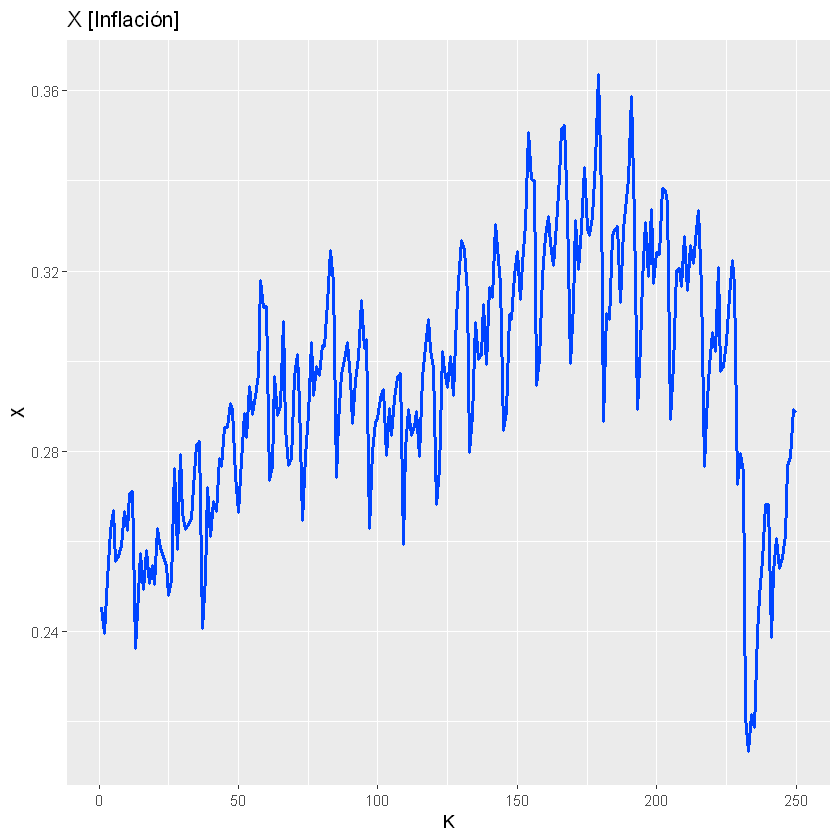

In [57]:
# Cálculo de las medias y desviaciones
Zb = matrix(data = NA, ncol = H, nrow = 1)
Zvar = matrix(data = NA, ncol = H, nrow = 1)
for (i in 1 : H){
  Zb[i] = sum(X.r[, i]) / R
  Zvar[i] = sqrt((sum((X.r[, i] - Zb[i]) ** 2)) / (R - 1))
}

# Crear vector de lambdas
Nlambdas = length(Lambdas)

# Datos transformados
Data.t = matrix(data = NA, ncol = Nlambdas, nrow = H)
for (i in 1 : Nlambdas){
  for (j in 1 : H){
    Data.t[j, i] = Zvar[j] / (Zb[j] ** (1 - Lambdas[i])) 
  }
}

# Matriz con los datos de los lambas
MLambda = matrix(data = NA, nrow = Nlambdas, ncol = 4)
colnames(MLambda) = c("Lambda", "M (Lambda)","SD (Lambda)","CV (Lambda)")
MLambda[, 1] = Lambdas

for (i in 1 : Nlambdas){
  MLambda[i, 2] = mean(Data.t[, i])
  MLambda[i, 3] = sqrt((sum((Data.t[, i] - MLambda[i, 2]) ** 2)) / (H - 1))
  MLambda[i, 4] = MLambda[i, 3] / MLambda[i, 2]
}

# Lambda óptimo (mínimo)
Opt = which.min(MLambda[, 4])                     # Número en que posición esta el mínimo 
Lambda_opt = Lambdas[Opt]                         # Lambda óptimo

# La transformación aplicada a los datos
if (Lambda_opt == 0){
  X = log(X)
} else {
  X = X ** Lambda_opt
}

# Gráfica de los datos
XV = data.frame(matrix(data = NA, nrow = K, ncol = 2))  
colnames(XV) = c('K', 'X')
XV[, 1] = seq(1, K, 1)
XV[, 2] = X[1 : K]
XV = with(XV, data.frame(K, X))

G_X <- ggplot(data = XV, mapping = aes(x = K, y = X)) +
  geom_line(colour = '#0044ff', size = 1) +
  labs(title = 'X [Inflación]')

# Salidas
MLambda
print(sprintf('La transformación aplicada a los datos es Lambda = %s', Lambda_opt))
# head(X)
head(XV)
G_X

## Estabilización de nivel

Se realiza con el objetivo de volver estacionaria la serie diferenciándola un número apropiado de veces, que, en caso de quedar sobrediferenciada se dificultará el proceso de identificación del posible proceso generador de la serie observada. En muy raras ocasiones es necesario difenrenciar un número alto de veces la serie y más si son de sentido económico.

J,S(J)
0,0.028651
1,0.015234
2,0.020592
3,0.022704


[1] "La diferencia aplicada a los datos es J = 1"


,K,X
,<dbl>,<dbl>
1,1,-0.005767372
2,2,0.011972475
3,3,0.010934213
4,4,0.004448316
5,5,-0.011308767
6,6,0.001092011


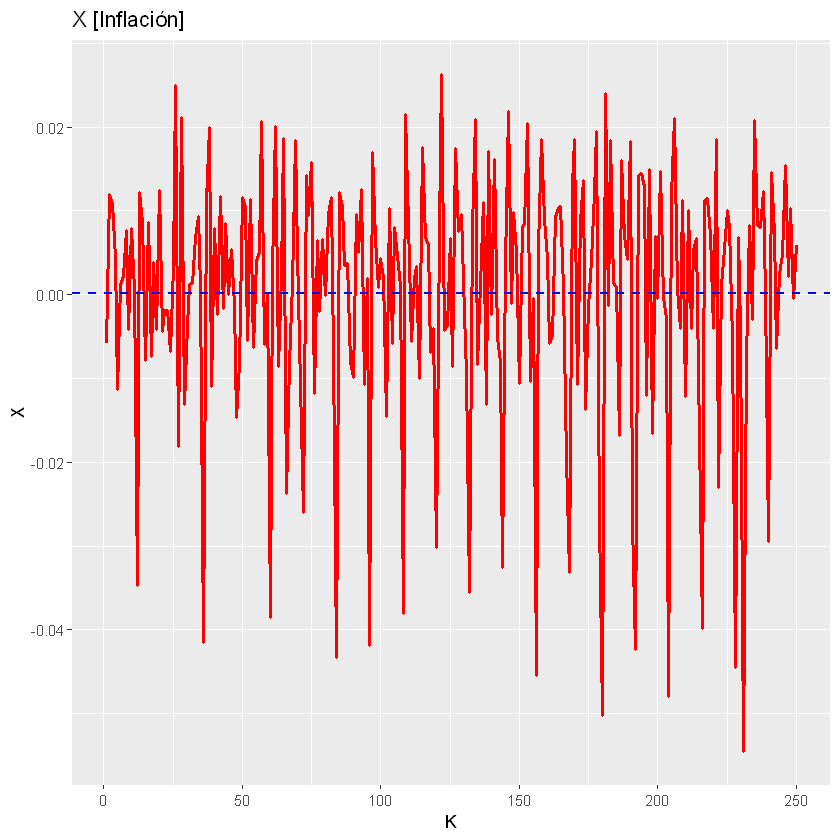

In [58]:
# Operador de diferencia
Diferencia = function(Data, K.Dif){                                 # Operador de diferencia
    Serie.dif = matrix(data = NA, nrow = (T - K.Dif), ncol = 1)
    for(i in 1: (T - K.Dif)){
        Serie.dif[i] <- Data[i + K.Dif] - Data[i]
    }
    return(Serie.dif)
}

# Matrix con los datos de J
S = matrix(data = NA, nrow = (K.Dif + 1), ncol = 2)
colnames(S) = c('J', 'S(J)')
S[, 1] = seq(0, K.Dif, 1)
for (i in 1 : K.Dif){
    # Diferenciación de la serie
    X.dif = matrix(data = NA, ncol = 1, nrow = (T - i))
    X.dif[, 1] = Diferencia(Data = X, K.Dif = i)

    # Cálculo de los S(j) diferenciadores (rezagados)
    S[1, 2] = round(sqrt((1 / (T - 0 - 1)) * sum((X - sum(X / (T - 0))) ** 2)), 6)                            # Diferenciación de J = 0
    S[(i + 1), 2] = round(sqrt((1 / (T - i - 1)) * sum((X.dif - sum(X.dif / (T - i))) ** 2)), 6)
}

# J óptimo (mínimo)
Opt = which.min(S[, 2])                     # Número en que posición esta el mínimo 
J_opt = S[Opt, 1]                           # Número de diferencias aplicadas a la serie

# La transformación aplicada a los datos
X = Diferencia(Data = X, K.Dif = J_opt)

# Gráfica de los datos
XN = data.frame(matrix(data = NA, nrow = K, ncol = 2))  
colnames(XN) = c('K', 'X')
XN[, 1] = seq(1, K, 1)
XN[, 2] = X[1 : K]
XN = with(XN, data.frame(K, X))
Xbb = mean(XN[, 2])

G_X <- ggplot(data = XN, mapping = aes(x = K, y = X)) +
  geom_line(colour = 'red', size = 1) +
  labs(title = 'X [Inflación]') +
  geom_hline(aes(yintercept = Xbb), color="blue",
        linetype = "dashed", size = 0.8)
    
# Salidas
S
print(sprintf('La diferencia aplicada a los datos es J = %s', J_opt))
# head(data.frame(X))
head(XN)
G_X
        

## Método de Cramer e identificación de modelos puros
- **Media muestral:**
$$
\bar{Z} = \dfrac{\sum_{t = 1}^{T}{Z_t}}{T}
$$
- **Varianza muestral:**
$$
\sigma^{2} = \dfrac{\sum_{t = 1}^{T}{(Z_t - \bar{Z}) ^ 2}}{T - 1}
$$
- **Auto - covarianza:**
$$
\gamma_{K} = \dfrac{\sum_{t = 1}^{T}{(Z_t - \bar{Z})(Z_{t + K} - \bar{Z})}}{T - 1}
$$
- **Auto - correlación:**
$$
\rho_{K} = \dfrac{\sum_{t = 1}^{T}{(Z_t - \bar{Z})(Z_{t + K} - \bar{Z})}}{\sum_{t = 1}^{T}{(Z_{t} - \bar{Z}) ^ 2}}
$$
- **Matriz de Phi_kk:**
$$
\phi_{kk} = \dfrac{
det\begin{vmatrix}
1 & \rho_{1} & \rho_{2} & \cdots & \rho_{K - 2} & \rho_{1}\\
\rho_{1} & 1 & \rho_{1} & \cdots & \rho_{K - 3} & \rho_{2}\\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
\rho_{K - 1} & \rho_{K - 2} & \rho_{K - 3} & \cdots & \rho_{1} & \rho_{K}
\end{vmatrix}
}{
det\begin{vmatrix}
1 & \rho_{1} & \rho_{2} & \cdots & \rho_{K - 2} & \rho_{K - 1}\\
\rho_{1} & 1 & \rho_{1} & \cdots & \rho_{K - 3} & \rho_{K - 2}\\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
\rho_{K-1} & \rho_{K-2} & \rho_{K-3} & \cdots & \rho_{1} & 1
\end{vmatrix}
}
$$
- **ACF:** Evalua la autocovarianza siendo el promedio de las covarianzas de las variables aleatorias realizadas que se encuentran en una separación de _k_ periodos de tiempo.
  
  Supuesto del valor esperado de E[Z_t] = 0
- **PACF:** Evalua la correlación entre Z_t y Z_t+K después de remover la dependencia lineal con los datos intermedios.
  
  Se debe de cumplir ceteris paribus.

[1] "Los datos se comportan como un AR puro de orden 42."
[1] "Los datos se comportan como un MA puro de orden 62."


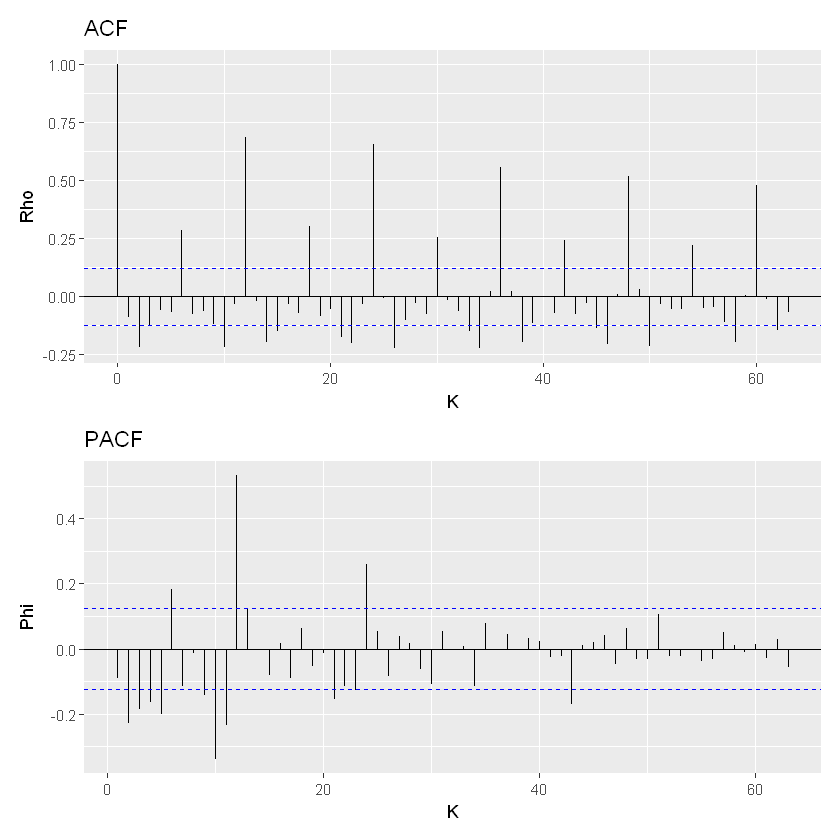

In [46]:
T.Series = function(X, K, alpha, ACF_d = FALSE, PACF_d = FALSE){
  # Construcción de los vectores y parámetros
  T = length(X)

  # Cálculo de variables
  Zb = sum(X) / T                                                             # Media muestral
  Cv = qt(p = (alpha / 2), df = (T - 1), lower.tail = FALSE) / sqrt(T)        # Valor crítico del intervalo de confianza

  # Función de autocovarianza
  Gamma = matrix(data = NA)                              
  for (i in 0 : K){
      Gamma[i + 1] = sum((X[1 : (T - i)] - Zb) * (X[(i + 1) : T] - Zb)) / (T - 1)
  }

  # Construcción ACF
  ACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
  ACF[, 1] = seq(0, K, 1)
  colnames(ACF) = c('K', 'Rho')
  for (i in 0 : K){
      ACF[i + 1, 2] = Gamma[i + 1] / Gamma[1]
  }
  ACF = with(ACF, data.frame(K, Rho))

  # Construcción PACF
  PACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))  
  PACF[, 1] = seq(1, (K + 1), 1)
  colnames(PACF) = c('K', 'Phi')                            
  for (k in 1 : K){
    Den = matrix(data = NA, nrow = k, ncol = k)
    for(i in 1 : k){
      for(j in 1 : (k - i + 1)){
        Den[j, j + i - 1] = ACF[i, 2]
        Den[j + i - 1, j] = ACF[i, 2]
      }
    }
    Num = Den
    Num[, k] = ACF[2 : (k + 1), 2]
    PACF[k, 2] = det(Num) / det(Den)
  }
  PACF = PACF[-(K + 1),]
  PACF = with(PACF, data.frame(K, Phi))

  # Gráfica conjunta de ACF y PACF
  G_ACF <- ggplot(data = ACF, mapping = aes(x = K, y = Rho)) +
        labs(title = 'ACF') +
        geom_hline(aes(yintercept = 0)) +
        geom_segment(mapping = aes(xend = K, yend = 0)) +
        geom_hline(aes(yintercept =   ), color="blue",
                linetype = "dashed", size = 0.5) + 
        geom_hline(aes(yintercept = -Cv), color="blue",
                linetype = "dashed", size = 0.5)
        
  G_PACF <- ggplot(data = PACF, mapping = aes(x = K, y = Phi)) +
        labs(title = 'PACF') +
        geom_hline(aes(yintercept = 0)) +
        geom_segment(mapping = aes(xend = K, yend = 0)) + 
        geom_hline(aes(yintercept = Cv), color="blue",
                linetype = "dashed", size = 0.5) + 
        geom_hline(aes(yintercept = -Cv), color="blue",
                linetype = "dashed", size = 0.5)

  # Condición de la función
  if (PACF_d == TRUE){
    print(head(PACF))
  }
  if (ACF_d == TRUE){
    print(head(ACF))
  }

  # Identificación del modelo AR
  CheckAR = matrix(data = NA, ncol = 1, nrow = K)
  for(i in 1 : K) {
      CheckAR[i] = between(0, (PACF[i, 2] - Cv), (PACF[i, 2] + Cv))
      if(CheckAR[i] == 1){
          next
      }
      AR_P = c(i) - 1
  }

  # Identificación del modelo MA
  CheckMA = matrix(data = NA, ncol = 1, nrow = K)
  for(i in 1 : K){
      CheckMA[i] = between(0, (ACF[i, 2] - Cv * (sqrt(1 + 2 * sum(ACF[(i + 1), 2] ** 2)))), (ACF[i, 2] + Cv) * (sqrt(1 + 2 * sum(ACF[(i + 1), 2] ** 2))))
      if(CheckMA[i] == 1){
          next
      }
      MA_Q = c(i) - 1
  }

  # Estimación comando ARIMA

  # Graficación de las pruebas y salidas
  print(sprintf('Los datos se comportan como un AR puro de orden %s.', AR_P))
  print(sprintf('Los datos se comportan como un MA puro de orden %s.', MA_Q))
  # print(Model)
  return(G_ACF / G_PACF)
}

T.Series(X = X, K = K, alpha = alpha, ACF_d = FALSE, PACF_d = FALSE)

## Supuestos

In [23]:
# AR_P = 2
# MA_Q = 2
# J_Opt = 0

# P_D = matrix(data = NA, nrow = AR_P + 1, ncol = MA_Q + 1)
# colnames(P_D) = seq(0, MA_Q, 1)
# rownames(P_D) = seq(0, AR_P, 1)
# for (i in 0 : AR_P){
#     for (j in 0 : MA_Q){
#         P_D[i + 1, j + 1] = arima(X, order = c(i, 0, j), method = c('ML'))$aic
#     }
# }

# # P_D óptimo (mínimo)
# Opt = which.min(P_D[2, ])                     # Número en que posición esta el mínimo 
# opt = P_D[Opt, 1]                           # Número de diferencias aplicadas a la serie

In [33]:
# Inputs
AR_P = 1
MA_Q = 0
J_Opt = 0

# Salidas
Model = arima(X, order = c(AR_P, 0, MA_Q), method = c('ML'))
At = Model$residuals
print(head(data.frame(At)))

            At
1 -0.061231802
2 -0.004185553
3  0.052467347
4 -0.030501930
5  0.023807426
6  0.025645203


### S1. Media 0 de residuales

- En caso de que se encuentre suficiente evidencia para rechazar media 0 en los errores con un nivel de significancia alpha, se debe replantear el coeficiente S(J) utilizado para la diferenciación de nivel.

In [34]:
# Media 0 de residuales
t = J_opt + AR_P + 1
T = length(At)
Ma = sum(At[t : T]) / (T - J_opt - AR_P)
Sigma_at = sqrt(t(At - Ma) %*% (At - Ma) / (T - J_opt - AR_P - MA_Q))
Stat = abs((sqrt(T - J_opt - AR_P) * Ma) / (Sigma_at)) 
Vc = qt(p = alpha, df = (T - AR_P - MA_Q - J_opt), lower.tail = FALSE)

# Salidas
if (Stat < Vc){
    print(sprintf('No hay suficiente evidencia para rechazar media 0 en los erorres con un alpha de %s', alpha))
} else {
    print(sprintf('Hay suficiente evidencia para rechazar media 0 en los erorres con un alpha de %s', alpha))
}

[1] "No hay suficiente evidencia para rechazar media 0 en los erorres con un alpha de 0.05"


### S2. Varianza cte de residuales

- Para rechazar la varianza constante de los residuales por inspección visual se deben encontrar patrones creciente o decrecientes mas no lateral, para la identificación de la misma se puede utilizar un intervalo de 2 desviaciones estandar de la media (0).
- En caso de que se encuentre suficiente evidencia para rechazar una varianza constante en los errores con un nivel de significancia alpha, se debe replantear el coeficiente Lambda utilizado para la diferenciación de varianza.

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.



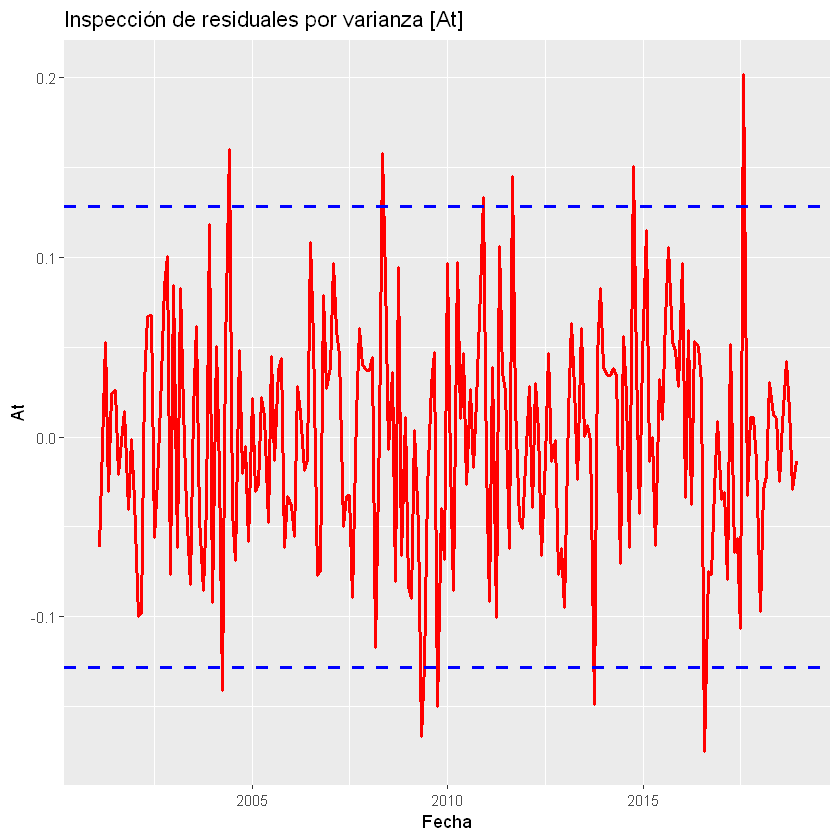

In [35]:
# Gráfica de los datos
At1 = data.frame(matrix(data = NA, nrow = T, ncol = 2))  
colnames(At1) = c('T', 'D.At')
At1[, 1] = Dates1[1 : T]
At1[, 2] = At
At1 = with(At1, data.frame(T, D.At))
At_sigma = 2 * Sigma_at

# Salidas
G_At1 <- ggplot(data = At1, mapping = aes(x = T, y = D.At)) +
      geom_line(colour = 'red', size = 1) +
      labs(title = 'Inspección de residuales por varianza [At]', x = 'Fecha', y = 'At') +
      geom_hline(aes(yintercept = At_sigma), color="blue",
            linetype = "dashed", size = 1) +
      geom_hline(aes(yintercept = -At_sigma), color="blue",
            linetype = "dashed", size = 1)
        
G_At1

### S3. Independencia de residuales

- En caso de que se encuentre suficiente evidencia para rechazar independencia en los errores con un nivel de significancia alpha, se debe replantear los coeficientes (P, Q) utilizados para la identificación del modelo.

In [36]:
L.B = function(At, K, AR_P){
    J_Opt = 0
    T = length(At)    
    Rho_at = matrix(data = NA, nrow = (T - K), ncol = 1)
    for (i in 1 : (T - K)){
        Rho_at[i] = sum(At[i] * At[(i + t)]) / sum(At ** 2)
    }

    # Prueba de Ljung - Box
    Q = (T - J_opt - AR_P) * (T - J_opt - AR_P + 2) * sum((sum(Rho_at) ** 2) / (T - J_opt - AR_P - K)) 
    Vc = qchisq(p = alpha, df = (K - AR_P - MA_Q))

    # Salida
    if (Q < Vc){
        print(sprintf('No hay suficiente evidencia para rechazar independencia en los erorres con un alpha de %s', alpha))
    } else {
        print(sprintf('Hay suficiente evidencia para rechazar independencia en los erorres con un alpha de %s', alpha))
    } 
}

print(sprintf("Q' = %s", Q))

[1] "No hay suficiente evidencia para rechazar independencia en los erorres con un alpha de 0.05"
[1] "Q' = 0.00498099233484874"


### S4. Normalidad de residuales
- En caso de que se encuentre suficiente evidencia para rechazar normalidad en los errores con un nivel de significancia alpha, se debe replantear el coeficiente Lambda utilizado para la diferenciación de varianza.

[1] "No hay suficiente evidencia para rechazar normalidad en los errores a un nivel de significancia alpha de: 0.05"


Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.



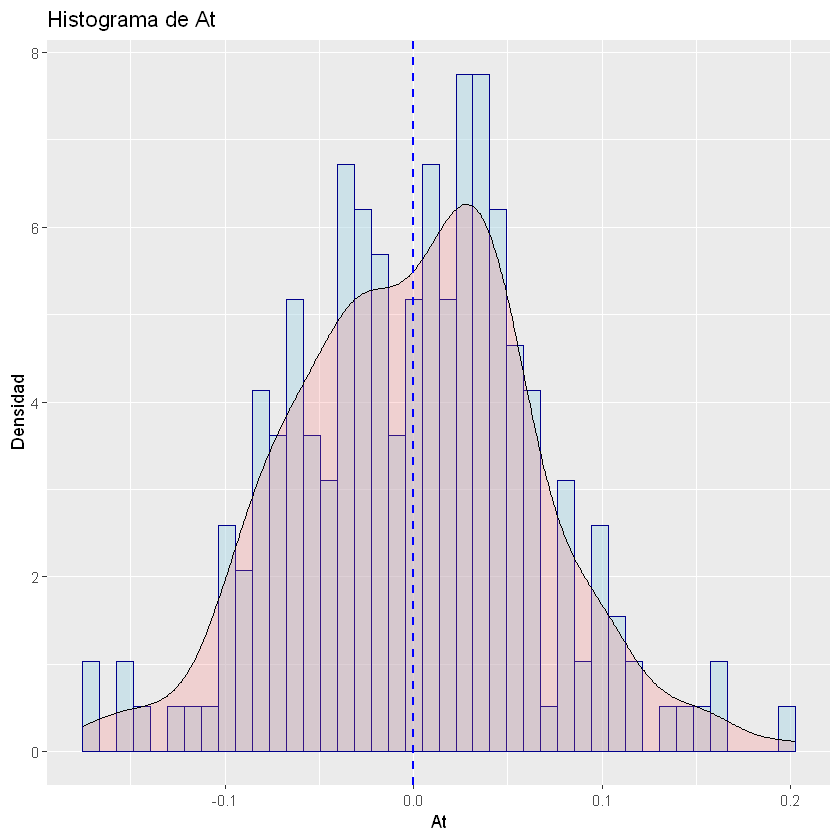

In [37]:
#Prueba Jarque Bera (Normalidad en el error)
JB = jarque.bera.test(At)                                         #Forma rápida
S = (sum((At - mean(At)) ** 3) / T) / (sqrt(as.numeric((t(At) %*% At) / T)) ** 3)           # Asimetría
K1 = (sum((At - mean(At)) ** 4) / T) / (sqrt(as.numeric((t(At) %*% At) / T)) ** 4)          # Kurtosis
JB = ((S ** 2 / 6) + ((K1 - 3) ** 2 / 24))
VcJB = qchisq(alpha, df = 2, lower.tail = FALSE)

# Salida
if(JB < VcJB){
    print(sprintf('No hay suficiente evidencia para rechazar normalidad en los errores a un nivel de significancia alpha de: %s', alpha))
} else {
    print(sprintf('Hay suficiente evidencia para rechazar normalidad en los errores a un nivel de significancia alpha de: %s', alpha))
}

# Histograma de los At
At1 = data.frame(matrix(data = NA, nrow = T, ncol = 2))
colnames(At1) = c('K', 'At')
At1[, 1] = seq(1, T, 1)
At1[, 2] = At
A_h = ggplot(At1, aes(x = At)) + 
    labs(title = 'Histograma de At', x = 'At', y = 'Densidad') +
    geom_histogram(aes(y = ..density..), colour = 'darkblue', fill = 'lightblue', alpha = 0.5, binwidth = 0.009) +
    geom_density(alpha = 0.2, fill = "#FF6666") +
    geom_vline(aes(xintercept= mean(At)), color = "blue", linetype = "dashed", size = 0.7) 
A_h

### S5. No existencia de observaciones aberrantes
- En caso de que se encuentre suficiente evidencia para rechazar independencia en los errores con un nivel de significancia alpha, se debe revisar en qué momentos del tiempo se presentaron esos datos y la importancia que tienen sobre el modelo.

[1] "Hay un total de 1 observaciones aberrantes"


Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.



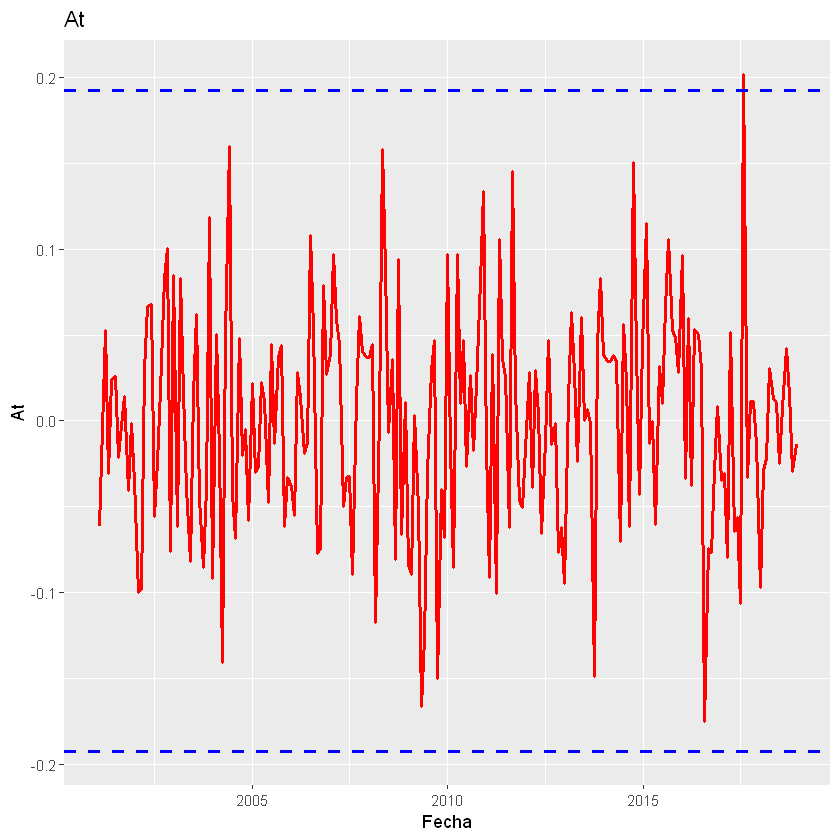

In [38]:
# Cantidad de observaciones aberrantes
Obs.aberr <- function(X){    
    T = length(X)
    Xmean = sum(X) / T
    Xsd = sd(X)  
    LS = Xmean + (3 * Xsd)
    LI = Xmean - (3 * Xsd)  
    D.aberr = c()

    for (i in 1 : T){
        if (X[i] < LS & X[i] > LI){
            D.aberr[i] = NA
        } else {
            D.aberr[i] = X[i]
        }
    }

    D.aberr = na.omit(D.aberr)  

    # Salidas
    print(sprintf('Hay un total de %s observaciones aberrantes', length(D.aberr)))
}

# Gráfica de los datos
At1 = data.frame(matrix(data = NA, nrow = T, ncol = 2))  
colnames(At1) = c('T', 'D.At')
At1[, 1] = Dates1[1 : T]
At1[, 2] = At
At1 = with(At1, data.frame(T, D.At))
At_sigma = 3 * Sigma_at

G_At1 <- ggplot(data = At1, mapping = aes(x = T, y = D.At)) +
  geom_line(colour = '#ff0202', size = 1) +
  labs(title = 'At', x = 'Fecha', y = 'At') +
  geom_hline(aes(yintercept = At_sigma), color="blue",
        linetype = "dashed", size = 1) +
  geom_hline(aes(yintercept = -At_sigma), color="blue",
        linetype = "dashed", size = 1)

# Salidas
Obs.aberr(X = At)
G_At1

### S6. Parsimonio
- En caso de que se encuentre suficiente evidencia para rechazar independencia en los errores con un nivel de significancia alpha, se debe replantear los coeficientes (P, Q) utilizados para la identificación del modelo.

In [39]:
Parsimonio = function(Delta, Delta.var){
    Desv = sqrt(Delta.var)
    Vec = Delta
    for (i in 1 : length(Delta)){
        LS = Delta[i] + (2 * Desv[i])
        LI = Delta[i] - (2 * Desv[i])
        if (LS > 0 & LI > 0 || LS < 0 & LI < 0){
            Vec[i] = "P. Necesario"
        } else {
            Vec[i]= "P. Innecesario"
        }
    }
    Vec = data.frame(Vec)
    colnames(Vec) = c('Test de parsimonia')
    print(data.frame(Vec))
}

Coeff <- Model$coef
Var.coeff <- diag(Model$var.coef)
Parsimonio(Delta = Coeff, Delta.var = Var.coeff)

          Test.de.parsimonia
ar1             P. Necesario
intercept     P. Innecesario


## Pronóstico

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.



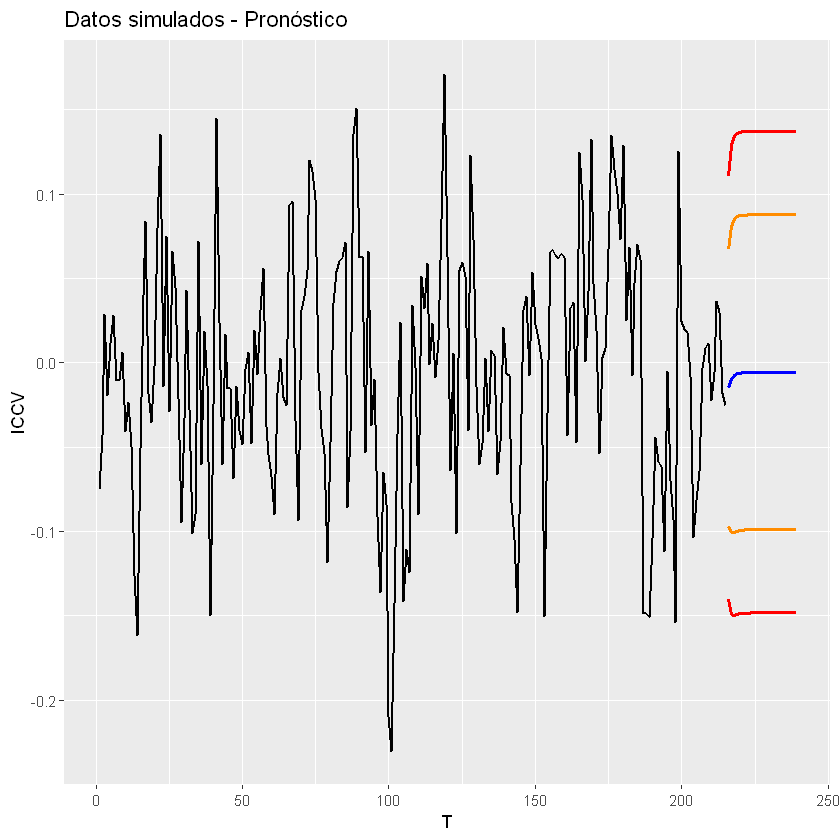

In [40]:
# Datos pronosticados
Pron = forecast(Model, h = P)
Upper = Pron$upper
Lower = Pron$lower
xp = Pron$x

# Media
Mid = Pron$mean
Mid1 = data.frame(matrix(data = NA, nrow = P, ncol = 2))
colnames(Mid1) = c('T', 'Media')
Mid1[, 1] = seq((length(xp) + 1), (length(xp) + P), 1)
Mid1[, 2] = Mid

# Upper 80% confidence level
Up80 = Upper[, 1]
Up.80 = data.frame(matrix(data = NA, nrow = P, ncol = 2))
colnames(Up.80) = c('T', 'Up80')
Up.80[, 1] = seq((length(xp) + 1), (length(xp) + P), 1)
Up.80[, 2] = Up80

# Lower 80% confidence level
Low80 = Lower[, 1]
Low.80 = data.frame(matrix(data = NA, nrow = P, ncol = 2))
colnames(Low.80) = c('T', 'Low80')
Low.80[, 1] = seq((length(xp) + 1), (length(xp) + P), 1)
Low.80[, 2] = Low80

# Upper 95% confidence level
Up95 = Upper[, 2]
Up.95 = data.frame(matrix(data = NA, nrow = P, ncol = 2))
colnames(Up.95) = c('T', 'Up95')
Up.95[, 1] = seq((length(xp) + 1), (length(xp) + P), 1)
Up.95[, 2] = Up95

# Lower 95% confidence level
Low95 = Lower[, 2]
Low.95 = data.frame(matrix(data = NA, nrow = P, ncol = 2))
colnames(Low.95) = c('T', 'Low95')
Low.95[, 1] = seq((length(xp) + 1), (length(xp) + P), 1)
Low.95[, 2] = Low95

# Datos muestrales
XII = data.frame(matrix(data = NA, nrow = length(xp), ncol = 2))
colnames(XII) = c('T', 'D.Obs')
XII[, 1] = seq(1, length(xp), 1)
XII[, 2] = xp

G_XII <- ggplot(data = XII, mapping = aes(x = T, y = D.Obs, group = 12)) +
  geom_line(colour = 'black', size = 0.8) +
  labs(title = 'Datos simulados - Pronóstico', x = 'T', y = 'ICCV') +
  geom_line(data = Mid1, mapping = aes(x = T, y = Media, group = 12), colour = 'blue', size = 1) +
  geom_line(data = Up.80, mapping = aes(x = T, y = Up80, group = 12), colour = '#ff8c00', size = 1) +
  geom_line(data = Low.80, mapping = aes(x = T, y = Low80, group = 12), colour = '#ff8c00', size = 1) +
  geom_line(data = Up.95, mapping = aes(x = T, y = Up95, group = 12), colour = 'red', size = 1) +
  geom_line(data = Low.95, mapping = aes(x = T, y = Low95, group = 12), colour = 'red', size = 1) +
  theme(legend.position="top")

G_XII

# Procedimientos AR[p] y MA[q] ~ Martha

## AR[1] y su representación MA[Inf]

  Phi_1
1  0.45
[1] "La varianza del proceso es 0.1505"
  K        Rho
1 0 1.00000000
2 1 0.45000000
3 2 0.20250000
4 3 0.09112500
5 4 0.04100625
6 5 0.01845281
  K           Phi
1 1  4.500000e-01
2 2  0.000000e+00
3 3  0.000000e+00
4 4 -8.700807e-18
5 5  3.915363e-18
6 6 -7.244878e-34
  K        Psi
1 0 1.00000000
2 1 0.45000000
3 2 0.20250000
4 3 0.09112500
5 4 0.04100625
6 5 0.01845281


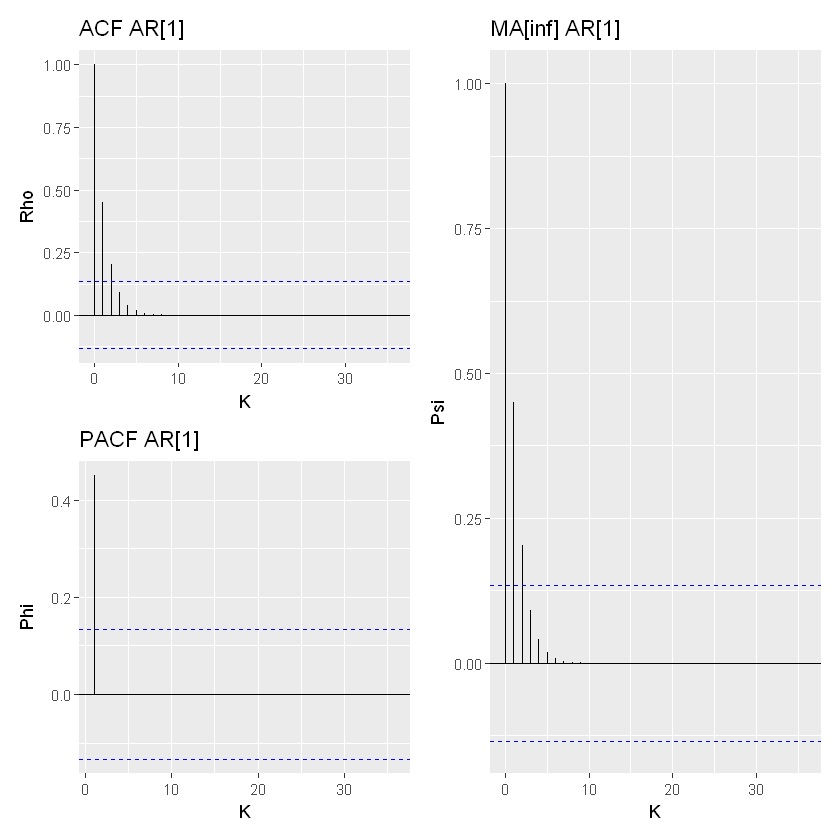

In [99]:
AR_1 = function(Phi, K, sigma_a, alpha = 0.05, MA_inf = FALSE){
    Phi_1 = Phi
    if (abs(Phi_1) < 1){
        # Construcción ACF
        ACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
        ACF[, 1] = seq(0, K, 1)
        colnames(ACF) = c('K', 'Rho')
        for (i in 0 : K){
            ACF[i + 1, 2] = Phi_1 ** i
        }
        ACF = with(ACF, data.frame(K, Rho))

        # Construcción PACF
        PACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))  
        PACF[, 1] = seq(1, (K + 1), 1)
        colnames(PACF) = c('K', 'Phi')                            
        for (k in 1 : K){
        Den = matrix(data = NA, nrow = k, ncol = k)
        for(i in 1 : k){
            for(j in 1 : (k - i + 1)){
            Den[j, j + i - 1] = ACF[i, 2]
            Den[j + i - 1, j] = ACF[i, 2]
            }
        }
        Num = Den
        Num[, k] = ACF[2 : (k + 1), 2]
        PACF[k, 2] = det(Num) / det(Den)
        }
        PACF = PACF[-(K + 1),]
        PACF = with(PACF, data.frame(K, Phi))

        # Varianza del proceso
        Gamma_0 = sigma_a / (1 - (Phi_1 ** 2))

        # Gráfica conjunta de ACF y PACF
        T = 216
        Cv = qt(p = (alpha / 2), df = (T - 1), lower.tail = FALSE) / sqrt(T)        # Valor crítico del intervalo de confianza
        G_ACF_1 <- ggplot(data = ACF, mapping = aes(x = K, y = Rho)) +
            labs(title = 'ACF AR[1]') +
            geom_hline(aes(yintercept = 0)) +
            geom_segment(mapping = aes(xend = K, yend = 0)) +
            geom_hline(aes(yintercept = Cv), color="blue",
                    linetype = "dashed") + 
            geom_hline(aes(yintercept = -Cv), color="blue",
                    linetype = "dashed")
                
        G_PACF_1 <- ggplot(data = PACF, mapping = aes(x = K, y = Phi)) +
            labs(title = 'PACF AR[1]') +
            geom_hline(aes(yintercept = 0)) +
            geom_segment(mapping = aes(xend = K, yend = 0)) + 
            geom_hline(aes(yintercept = Cv), color="blue",
                    linetype = "dashed") + 
            geom_hline(aes(yintercept = -Cv), color="blue",
                    linetype = "dashed")
        
        if (MA_inf == TRUE){
            # Construcción ACF (Solución de la función generadora)
            ACF_MA = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
            ACF_MA[, 1] = seq(0, K, 1)
            colnames(ACF_MA) = c('K', 'Psi')
            for (i in 0 : K){
                ACF_MA[i + 1, 2] = as.numeric(PACF[1, 2] ** i)
            }
            ACF_MA = with(ACF_MA, data.frame(K, Psi))

            # Gráfica
            G_MA <- ggplot(data = ACF_MA, mapping = aes(x = K, y = Psi)) +
                labs(title = 'MA[inf] AR[1]') +
                geom_hline(aes(yintercept = 0)) +
                geom_segment(mapping = aes(xend = K, yend = 0)) +
                geom_hline(aes(yintercept = Cv), color="blue",
                        linetype = "dashed") + 
                geom_hline(aes(yintercept = -Cv), color="blue",
                        linetype = "dashed")


            # Salidas
            print(data.frame(Phi_1))
            print(sprintf('La varianza del proceso es %s', round(Gamma_0, 4)))
            print(data.frame(head(ACF)))
            print(data.frame(head(PACF)))
            print(data.frame(head(ACF_MA)))
            return((G_ACF_1 / G_PACF_1) |  G_MA)
        } else {
            # Salidas
            print(data.frame(Phi_1))
            print(sprintf('La varianza del proceso es %s', round(Gamma_0, 4)))
            print(data.frame(head(ACF)))
            print(data.frame(head(PACF)))
            return(G_ACF_1 / G_PACF_1)
        }

    } else {
        print(sprintf('El proceso no es estacionario al tener su factor |%s| > 1', round(G, 4)))
    }
}

AR_1(Phi = c(0.45), K = 36, sigma_a = 0.12, MA_inf = TRUE)

## AR[2] y su representación MA[Inf]

      G
1  0.32
2 -0.41
  K           Rho
1 0  1.0000000000
2 1  0.0795615276
3 2  0.1240394625
4 3 -0.0007250792
5 4  0.0163392346
6 5 -0.0015656615
  K           Phi
1 1  7.956153e-02
2 2  1.184593e-01
3 3 -1.923966e-02
4 4  3.125983e-03
5 5 -5.079022e-04
6 6  8.252274e-05
[1] "La varianza del proceso es 0.0514"
  K           Psi
1 0  1.0000000000
2 1  0.0795615276
3 2  0.1240394625
4 3 -0.0007250792
5 4  0.0163392346
6 5 -0.0015656615


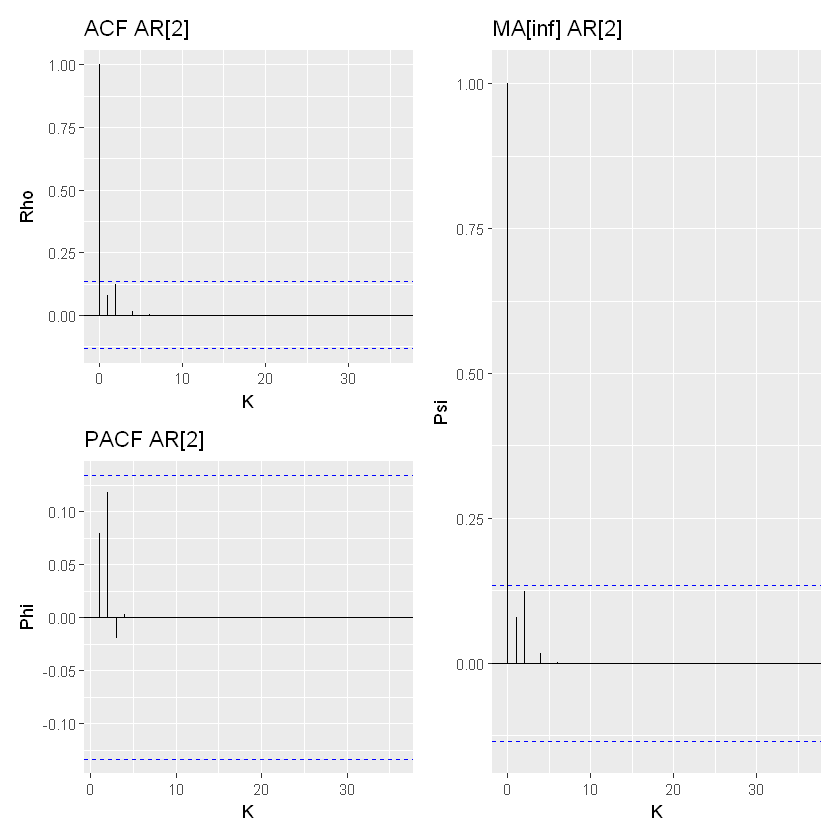

In [100]:
AR_2 = function(Phi, K, sigma_a, alpha = 0.05, MA_inf = FALSE){

    # Cálculo de los factores con su parte imaginaria
    Phi = matrix(data = c(-1, c(Phi)), nrow = 3, ncol = 1) * -1
    G = matrix(data = c(as.complex(polyroot(Phi)) ** -1), nrow = 2, ncol = 1)               # Polyroot devuelve las raices, ** -1 = Factores
    for (i in 1 : length(G)){
        if (sum(round(Im(G), 10)) == 0){
            G = G
        } else {
            Re_G = Re(G)
            Im_G = Im(G)
            for (i in 1 : length(G)){                                                               # Convierten los números complejos en reales
                G[i] = sqrt(Re_G[i] ** 2 + Im_G[i] ** 2)
            }
        }
    }

    # Identificación estacionareidad
    G = round(Re(G), 10)
    Check = matrix(data = NA, nrow = length(G), ncol = 1)
    for (i in 1 : length(G)){
        if (abs(G[i]) < 1){
            Check[i] = 1
        } else {
            Check[i] = 0
        }
    }

    if (sum(Check) == length(G)){
        Rho = matrix(data = NA, nrow = length(G), ncol = 1)
        Rho[1] = 1
        Rho[2] = (Phi[2]) / (1 - (Phi[3]))

        # Identifiación de raices iguales
        if((G[1]) == (G[2])){                                           # Factores iguales
            FG = matrix(data = NA, nrow = 2, ncol = 2)
            FG = rbind(c(1, 0), c(G))                                   # Cálculo de los valores iniciales con factores iguales
            A = as.matrix(solve(FG) %*% Rho)

            # Construcción ACF (Solución de la función generadora)
            ACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
            ACF[, 1] = seq(0, K, 1)
            colnames(ACF) = c('K', 'Rho')
            for (i in 0 : K){
                ACF[i + 1, 2] = as.numeric((A[1] * (G[1] ** i)) + (A[2] * (G[2] ** i) * i))
            }
            ACF = with(ACF, data.frame(K, Rho))
        } else{                                                         # Factores diferentes
            FG = matrix(data = NA, nrow = 2, ncol = 2)
            FG = rbind(c(1, 1), c(G))                                   # Cálculo de los valores iniciales con factores iguales
            A = as.matrix(solve(FG) %*% Rho)
            
            # Construcción ACF (Solución de la función generadora)
            ACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
            ACF[, 1] = seq(0, K, 1)
            colnames(ACF) = c('K', 'Rho')
            for (i in 0 : K){
                ACF[i + 1, 2] = as.numeric((A[1] * (G[1] ** i)) + (A[2] * (G[2] ** i)))
            }
            ACF = with(ACF, data.frame(K, Rho))
        }

        # Construcción PACF (Usando Cramer)
        PACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))  
        PACF[, 1] = seq(1, (K + 1), 1)
        colnames(PACF) = c('K', 'Phi')                            
        for (k in 1 : K){
        Den = matrix(data = NA, nrow = k, ncol = k)
        for(i in 1 : k){
            for(j in 1 : (k - i + 1)){
            Den[j, j + i - 1] = ACF[i, 2]
            Den[j + i - 1, j] = ACF[i, 2]
            }
        }
        Num = Den
        Num[, k] = ACF[2 : (k + 1), 2]
        PACF[k, 2] = det(Num) / det(Den)
        }
        PACF = PACF[-(K + 1),]
        PACF = with(PACF, data.frame(K, Phi))

        # Cálculo de la varianza del proceso
        Phi = Phi * -1
        Gamma_0 = ((1 - Phi[3]) * sigma_a) / ((1 + Phi[3]) * (1 - Phi[2] - Phi[3]) * (1 + Phi[2] - Phi[3]))

        # Gráfica conjunta de ACF y PACF
        T = 216
        Cv = qt(p = (alpha / 2), df = (T - 1), lower.tail = FALSE) / sqrt(T)        # Valor crítico del intervalo de confianza
        G_ACF_2 <- ggplot(data = ACF, mapping = aes(x = K, y = Rho)) +
            labs(title = 'ACF AR[2]') +
            geom_hline(aes(yintercept = 0)) +
            geom_segment(mapping = aes(xend = K, yend = 0)) +
            geom_hline(aes(yintercept = Cv), color="blue",
                    linetype = "dashed") + 
            geom_hline(aes(yintercept = -Cv), color="blue",
                    linetype = "dashed")
                
        G_PACF_2 <- ggplot(data = PACF, mapping = aes(x = K, y = Phi)) +
            labs(title = 'PACF AR[2]') +
            geom_hline(aes(yintercept = 0)) +
            geom_segment(mapping = aes(xend = K, yend = 0)) + 
            geom_hline(aes(yintercept = Cv), color="blue",
                    linetype = "dashed") + 
            geom_hline(aes(yintercept = -Cv), color="blue",
                    linetype = "dashed")

        # Representación MA infinita de un AR[2]
        if (MA_inf == TRUE){
            if((G[1]) == (G[2])){                                           # Factores iguales
                Psi = matrix(data = c(1, PACF[1, 2]), nrow = 2, ncol = 1)
                FG = matrix(data = NA, nrow = 2, ncol = 2)
                FG = rbind(c(1, 0), c(G))                                   # Cálculo de los valores iniciales con factores iguales
                A = as.matrix(solve(FG) %*% Psi)

                # Construcción ACF (Solución de la función generadora)
                ACF_MA = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
                ACF_MA[, 1] = seq(0, K, 1)
                colnames(ACF_MA) = c('K', 'Psi')
                for (i in 0 : K){
                    ACF_MA[i + 1, 2] = as.numeric((A[1] * (G[1] ** i)) + (A[2] * (G[2] ** i)))
                }
                ACF_MA = with(ACF_MA, data.frame(K, Psi))
            } else{                                                         # Factores diferentes
                Psi = matrix(data = c(1, PACF[1, 2]), nrow = 2, ncol = 1)
                FG = matrix(data = NA, nrow = 2, ncol = 2)
                FG = rbind(c(1, 1), c(G))                                   # Cálculo de los valores iniciales con factores iguales
                A = as.matrix(solve(FG) %*% Psi)

                # Construcción ACF (Solución de la función generadora)
                ACF_MA = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
                ACF_MA[, 1] = seq(0, K, 1)
                colnames(ACF_MA) = c('K', 'Psi')
                for (i in 0 : K){
                    ACF_MA[i + 1, 2] = as.numeric((A[1] * (G[1] ** i)) + (A[2] * (G[2] ** i)))
                }
                ACF_MA = with(ACF_MA, data.frame(K, Psi))
            }

            # Gráfica conjunta de ACF
            G_MA <- ggplot(data = ACF_MA, mapping = aes(x = K, y = Psi)) +
                labs(title = 'MA[inf] AR[2]') +
                geom_hline(aes(yintercept = 0)) +
                geom_segment(mapping = aes(xend = K, yend = 0)) +
                geom_hline(aes(yintercept = Cv), color="blue",
                        linetype = "dashed") + 
                geom_hline(aes(yintercept = -Cv), color="blue",
                        linetype = "dashed")

            # Salidas
            print(data.frame(G))
            print(data.frame(head(ACF)))
            print(data.frame(head(PACF)))
            print(sprintf('La varianza del proceso es %s', round(Gamma_0, 4)))
            print(data.frame(head(ACF_MA)))
            return((G_ACF_2 / G_PACF_2) | G_MA)
        } else {
            # Salidas
            print(data.frame(G))
            print(data.frame(head(ACF)))
            print(data.frame(head(PACF)))
            print(sprintf('La varianza del proceso es %s', round(Gamma_0, 4)))
            return(G_ACF_2 / G_PACF_2)
        }
    } else {
        print(sprintf('El proceso no es estacionario al tener sus factores |%s| > 1', round(G, 4)))
    }
}

AR_2(Phi = c(-0.09, 0.1312), K = 36, sigma_a = 0.05, MA_inf = TRUE)

## AR[3] y su representación MA[Inf]

[1] "Todos los factores son diferentes."
           G
1  0.6300752
2  0.4399029
3 -0.2099780
  K       Rho
1 0 1.0000000
2 1 0.7851921
3 2 0.5770670
4 3 0.3968551
5 4 0.2653012
6 5 0.1737388
  K           Phi
1 1  7.851921e-01
2 2 -1.029005e-01
3 3 -5.820000e-02
4 4  1.030473e-11
5 5  2.623706e-12
6 6 -3.443066e-17
  Gamma     Valor
1     0 0.3173530
2     1 0.2491831
3     2 0.1831340
  K       Psi
1 0 1.0000000
2 1 0.7851921
3 2 0.5136261
4 3 0.3422959
5 4 0.2217109
6 5 0.1428078


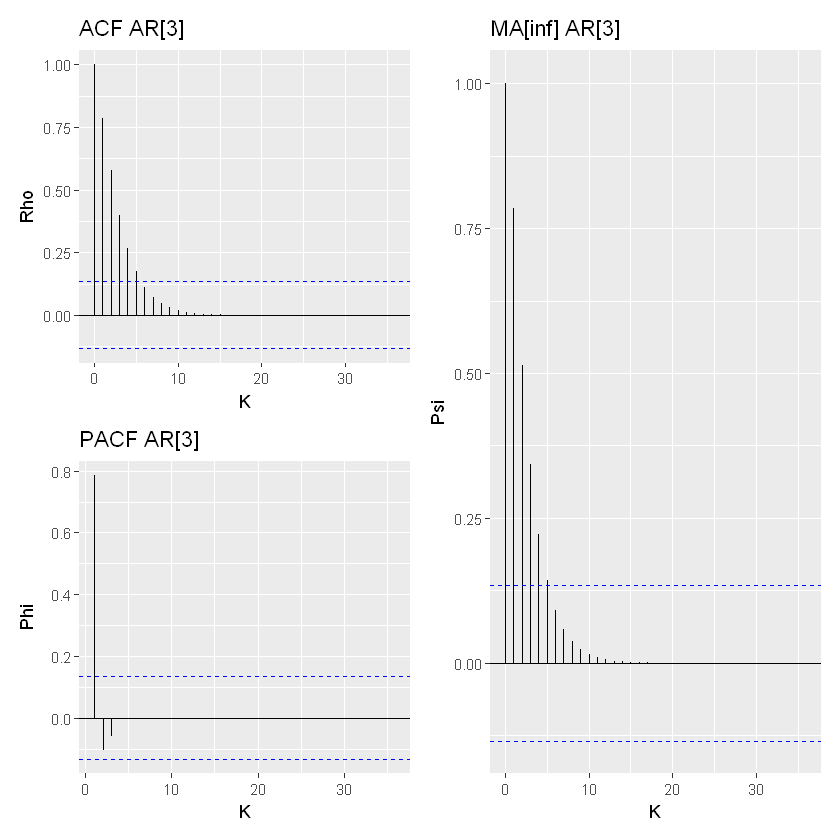

In [101]:
AR_3 = function(Phi, K, sigma_a, alpha = 0.05, MA_inf = FALSE){
    # Cálculo de los factores con su parte imaginaria
    Phi = matrix(data = c(-1, c(Phi)), nrow = 4, ncol = 1) * -1
    G = matrix(data = c(as.complex(polyroot(Phi)) ** -1), nrow = 3, ncol = 1)               # Polyroot devuelve las raices, ** -1 = Factores
    for (i in 1 : length(G)){
        if (sum(round(Im(G), 10)) == 0){
            G = G
        } else {
            Re_G = Re(G)
            Im_G = Im(G)
            for (i in 1 : length(G)){                                                               # Convierten los números complejos en reales
                G[i] = sqrt(Re_G[i] ** 2 + Im_G[i] ** 2)
            }
        }
    }

    # Identificación estacionareidad
    NG = length(G)
    G = round(Re(G), 10)
    Check = matrix(data = NA, nrow = NG, ncol = 1)
    for (i in 1 : NG){
        if (abs(G[i]) < 1){
            Check[i] = 1
        } else {
            Check[i] = 0
        }
    }

    # Identificación de factores iguales 
    Check_fact = matrix(data = sort(G, decreasing = TRUE), nrow = NG, ncol = 2)
    for (i in 2 : NG){
        Check_fact[1, 2] = 1
        if (Check_fact[i, 1] == Check_fact[(i - 1), 1]){                                      
            Check_fact[i, 2] = Check_fact[(i - 1), 2] + 1
        } else {                                                                    
            Check_fact[i, 2] = 1
        }
    }

    # Cálculo de los valores iniciales
    if (sum(Check) == 3){
        
        # Cálculo de los Rho
        Phi = Phi * -1
        Rho1 = (Phi[2] + (Phi[3] * Phi[4])) / (1 - Phi[3] - (Phi[4] * Phi[2]) - Phi[4] ** 2)
        Rho2 = Rho1 * (Phi[2] + Phi[4]) + Phi[3]
        Rho = matrix(data = c(1, Rho1, Rho2), nrow = NG, ncol = 1)         

        # Cálculo de la ACF con y sin factores distintos
        if (sum(Check_fact[, 2]) == NG){
            Ginv = rbind(c(1, 1, 1), c(G), c(G ** 2))               # Cálculo de los valores iniciales con factores diferentes
            A = as.matrix(solve(Ginv) %*% Rho)
            print('Todos los factores son diferentes.')

            # Construcción ACF (Solución de la función generadora)
            ACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
            ACF[, 1] = seq(0, K, 1)
            colnames(ACF) = c('K', 'Rho')
            for (i in 0 : K){
                ACF[i + 1, 2] = as.numeric((A[1] * (G[1] ** i)) + (A[2] * (G[2] ** i)) + (A[3] * (G[3] ** i)))
            }
            ACF = with(ACF, data.frame(K, Rho))

        }
        if (sum(Check_fact[, 2]) == (NG + 1)){
            Ginv = rbind(c(1, 1, 0), c(G), c(G ** 2))               # Cálculo de los valores iniciales con factores iguales
            A = as.matrix(solve(Ginv) %*% Rho)
            print('Dos factores son iguales.')

            # Construcción ACF (Solución de la función generadora)
            ACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
            ACF[, 1] = seq(0, K, 1)
            colnames(ACF) = c('K', 'Rho')
            FG = matrix(data = NA, ncol = NG, nrow = (K + 1))
            for (j in 1 : NG){
                for (i in 0 : K){
                    if (Check_fact[j, 2] == 1){
                        FG[(i + 1), j] = A[j] * (G[j] ** i)
                    } else {
                        FG[(i + 1), j] = A[j] * (G[j] ** i) * i
                    }
                }
            }
            for (i in 0 : K){
                ACF[i + 1, 2] = as.numeric(sum(FG[(i + 1), ]))
            }
            ACF = with(ACF, data.frame(K, Rho))

        }
        if (sum(Check_fact[, 2]) == (NG + 3)){
            G_3 = c(G[1], (2 * G[2]), (4 * G[3]))
            Ginv = rbind(c(1, 0, 0), c(G), c(G_3 ** 2))              # Cálculo de los valores iniciales con factores iguales
            A = as.matrix(solve(Ginv) %*% Rho)
            print('Tres factores son iguales.')

            # Construcción ACF (Solución de la función generadora)
            ACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
            ACF[, 1] = seq(0, K, 1)
            colnames(ACF) = c('K', 'Rho')
            FG = matrix(data = NA, ncol = NG, nrow = (K + 1))
            for (j in 1 : NG){
                FG[(i + 1), j] = A[j] * (G[j] ** i) * i
            }
            for (i in 0 : K){
                ACF[i + 1, 2] = as.numeric(sum(FG[(i + 1), ]))
            }
            ACF = with(ACF, data.frame(K, Rho))

        }

        # Construcción PACF (Usando Cramer)
        PACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))  
        PACF[, 1] = seq(1, (K + 1), 1)
        colnames(PACF) = c('K', 'Phi')                            
        for (k in 1 : K){
        Den = matrix(data = NA, nrow = k, ncol = k)
        for(i in 1 : k){
            for(j in 1 : (k - i + 1)){
            Den[j, j + i - 1] = ACF[i, 2]
            Den[j + i - 1, j] = ACF[i, 2]
            }
        }
        Num = Den
        Num[, k] = ACF[2 : (k + 1), 2]
        PACF[k, 2] = det(Num) / det(Den)
        }
        PACF = PACF[-(K + 1),]
        PACF = with(PACF, data.frame(K, Phi))

        # Varianza del proceso (Gamma_0_1_2)
        F1 = c((1 - (Phi[2] ** 2) - (Phi[3] ** 2) - (Phi[4] ** 2)), (-2 * Phi[3] * (Phi[2] + Phi[4])), (-2 * Phi[2] * Phi[4]))
        F2 = c((-Phi[2]), (1 - Phi[3]), (-Phi[4]))
        F3 = c((-Phi[3]), -(Phi[2] + Phi[4]), (1))
        C2 = matrix(data = c(sigma_a, 0, 0), ncol = 1, nrow = 3)
        Gamma = matrix(data = rbind(F1, F2, F3), ncol = 3, nrow = 3)
        Gamma_1_2_3 = matrix(data = NA, ncol = 2, nrow = 3)
        colnames(Gamma_1_2_3) = c('Gamma', 'Valor')
        Gamma_1_2_3[, 1] = seq(0, 2, 1)
        Gamma_1_2_3[, 2] = solve(Gamma) %*% C2

        # Gráfica conjunta de ACF y PACF
        T = 216
        Cv = qt(p = (alpha / 2), df = (T - 1), lower.tail = FALSE) / sqrt(T)        # Valor crítico del intervalo de confianza
        G_ACF_3 <- ggplot(data = ACF, mapping = aes(x = K, y = Rho)) +
            labs(title = 'ACF AR[3]') +
            geom_hline(aes(yintercept = 0)) +
            geom_segment(mapping = aes(xend = K, yend = 0)) +
            geom_hline(aes(yintercept = Cv), color="blue",
                    linetype = "dashed") + 
            geom_hline(aes(yintercept = -Cv), color="blue",
                    linetype = "dashed")
                
        G_PACF_3 <- ggplot(data = PACF, mapping = aes(x = K, y = Phi)) +
            labs(title = 'PACF AR[3]') +
            geom_hline(aes(yintercept = 0)) +
            geom_segment(mapping = aes(xend = K, yend = 0)) + 
            geom_hline(aes(yintercept = Cv), color="blue",
                    linetype = "dashed") + 
            geom_hline(aes(yintercept = -Cv), color="blue",
                    linetype = "dashed")   

        # Representación MA infinita de un AR[3]
        if (MA_inf == TRUE){
            Psi_2 = PACF[1, 2]
            Psi_3 = (PACF[1, 2] ** 2) + PACF[2, 2]
            Psi = matrix(data = c(1, Psi_2, Psi_3), nrow = 3, ncol = 1)

            # Cálculo de la ACF con y sin factores distintos
            if (sum(Check_fact[, 2]) == NG){
                Ginv = rbind(c(1, 1, 1), c(G), c(G ** 2))               # Cálculo de los valores iniciales con factores diferentes
                A = as.matrix(solve(Ginv) %*% Psi)

                # Construcción ACF (Solución de la función generadora)
                ACF_MA = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
                ACF_MA[, 1] = seq(0, K, 1)
                colnames(ACF_MA) = c('K', 'Psi')
                for (i in 0 : K){
                    ACF_MA[i + 1, 2] = as.numeric((A[1] * (G[1] ** i)) + (A[2] * (G[2] ** i)) + (A[3] * (G[3] ** i)))
                }
                ACF_MA = with(ACF_MA, data.frame(K, Psi))

            } else {
                Ginv = rbind(c(1, 1, 0), c(G), c(G ** 2))               # Cálculo de los valores iniciales con factores iguales
                A = as.matrix(solve(Ginv) %*% Psi)

                # Construcción ACF (Solución de la función generadora)
                ACF_MA = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
                ACF_MA[, 1] = seq(0, K, 1)
                colnames(ACF_MA) = c('K', 'Psi')
                FG = matrix(data = NA, ncol = NG, nrow = (K + 1))
                for (j in 1 : NG){
                    for (i in 0 : K){
                        if (Check_fact[j, 2] == 1){
                            FG[(i + 1), j] = A[j] * (G[j] ** i)
                        } else {
                            FG[(i + 1), j] = A[j] * (G[j] ** i) * i
                        }
                    }
                }
                for (i in 0 : K){
                    ACF_MA[i + 1, 2] = as.numeric(sum(FG[(i + 1), ]))
                }
                ACF_MA = with(ACF_MA, data.frame(K, Psi))

            }

            # Gráfica conjunta de ACF y PACF
            G_MA <- ggplot(data = ACF_MA, mapping = aes(x = K, y = Psi)) +
                labs(title = 'MA[inf] AR[3]') +
                geom_hline(aes(yintercept = 0)) +
                geom_segment(mapping = aes(xend = K, yend = 0)) +
                geom_hline(aes(yintercept = Cv), color="blue",
                        linetype = "dashed") + 
                geom_hline(aes(yintercept = -Cv), color="blue",
                        linetype = "dashed")

            # Salidas
            print(data.frame(G))
            print(data.frame(head(ACF)))
            print(data.frame(head(PACF)))
            print(data.frame(Gamma_1_2_3))
            print(data.frame(head(ACF_MA)))
            return((G_ACF_3 / G_PACF_3) | G_MA)
        } else {
            # Salidas
            print(A)
            print(data.frame(G))
            print(data.frame(head(ACF)))
            print(data.frame(head(PACF)))
            print(data.frame(Gamma_1_2_3))
            return(G_ACF_3 / G_PACF_3)
        }
    } else {
        print(sprintf('El proceso no es estacionario al tener sus factores |%s| > 1', round(G, 4)))
    }
}

AR_3(Phi = c(0.86, -0.0525, -0.0582), K = 36, sigma_a = 0.12, MA_inf = TRUE)

## MA[1] con su representación AR[Inf]

  Phi_1
1  0.45
     K   Gamma
[1,] 0  0.1443
[2,] 1 -0.0540
  K        Rho
1 0  1.0000000
2 1 -0.3742204
  K        Phi
1 0 1.00000000
2 1 0.45000000
3 2 0.20250000
4 3 0.09112500
5 4 0.04100625
6 5 0.01845281


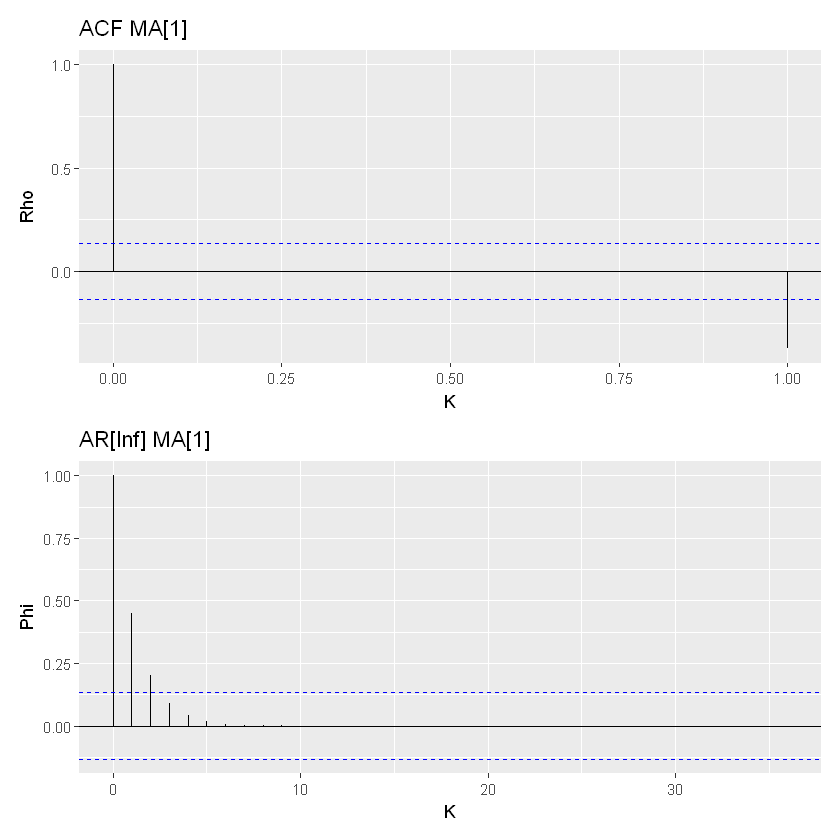

In [102]:
MA_1 = function(Phi, K, sigma_a, alpha = 0.05){
    Phi_1 = Phi
    if (abs(Phi_1) < 1){
        # Construcción ACF
        ACF = data.frame(matrix(data = NA, nrow = 2, ncol = 2))
        colnames(ACF) = c('K', 'Rho')
        ACF[, 1] = seq(0, 1, 1)
        ACF[1, 2] = 1
        ACF[2, 2] = (-Phi_1) / (1 + (Phi_1 ** 2))

        # Construcción PACF
        PACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
        PACF[, 1] = seq(0, K, 1)
        colnames(PACF) = c('K', 'Phi')
        for (i in 0 : K){
            PACF[i + 1, 2] = Phi_1 ** i
        }
        PACF = with(PACF, data.frame(K, Phi))

        # Varianza del proceso
        Gamma = matrix(data = NA, ncol = 2, nrow = 2)
        colnames(Gamma) = c('K', 'Gamma')
        Gamma[, 1] = seq(0, 1, 1)
        Gamma[1, 2] = sigma_a * (1 + (Phi_1 ** 2))
        Gamma[2, 2] = -Phi_1 * sigma_a

        # Gráfica conjunta de ACF y PACF
        T = 216
        Cv = qt(p = (alpha / 2), df = (T - 1), lower.tail = FALSE) / sqrt(T)        # Valor crítico del intervalo de confianza
        G_ACF_1 <- ggplot(data = ACF, mapping = aes(x = K, y = Rho)) +
            labs(title = 'ACF MA[1]') +
            geom_hline(aes(yintercept = 0)) +
            geom_segment(mapping = aes(xend = K, yend = 0)) +
            geom_hline(aes(yintercept = Cv), color="blue",
                    linetype = "dashed") + 
            geom_hline(aes(yintercept = -Cv), color="blue",
                    linetype = "dashed")
                
        G_PACF_1 <- ggplot(data = PACF, mapping = aes(x = K, y = Phi)) +
            labs(title = 'AR[Inf] MA[1]') +
            geom_hline(aes(yintercept = 0)) +
            geom_segment(mapping = aes(xend = K, yend = 0)) + 
            geom_hline(aes(yintercept = Cv), color="blue",
                    linetype = "dashed") + 
            geom_hline(aes(yintercept = -Cv), color="blue",
                    linetype = "dashed")

        # Salidas
        print(data.frame(Phi_1))
        print(Gamma)
        print(data.frame(head(ACF)))
        print(data.frame(head(PACF)))
        return(G_ACF_1 / G_PACF_1)
    } else {
        print(sprintf('El proceso no es invertible al tener su factor |%s| > 1', round(G, 4)))
    }
}

MA_1(Phi = c(0.45), K = 36, sigma_a = 0.12)

## MA[2] con su representación AR[Inf]

      G
1 -0.86
2  0.41
  K        Rho
1 1  1.0000000
2 2 -0.4587411
3 3  0.2657468
  K        Phi
1 0  1.0000000
2 1 -0.4500000
3 2  0.5551000
4 3 -0.4084650
5 4  0.3795375
6 5 -0.3148166
[1] "La varianza del proceso es 0.0663"


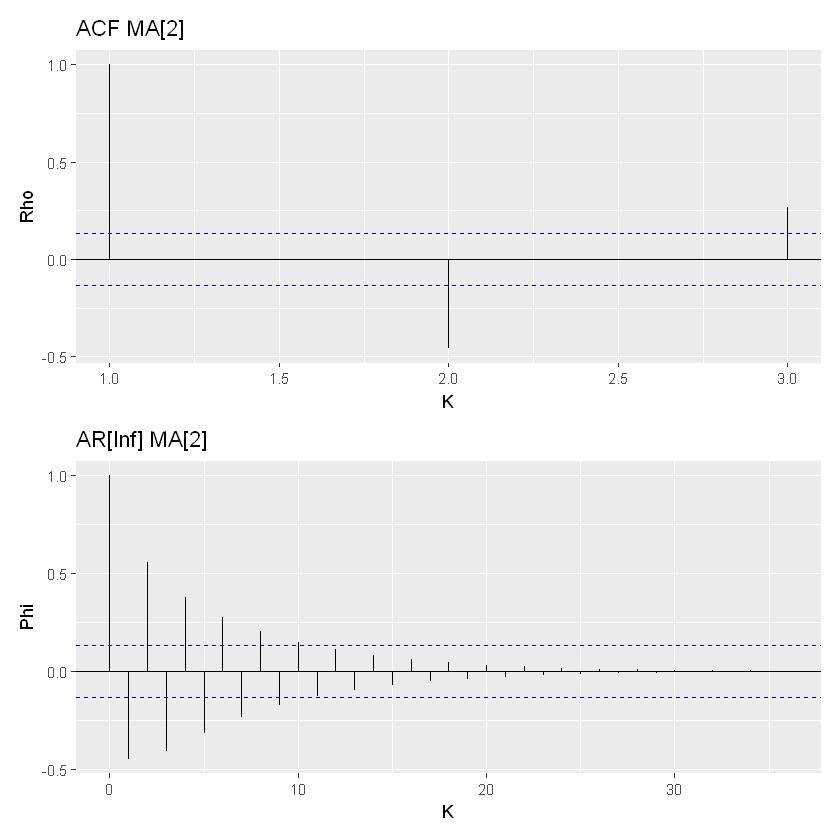

In [103]:
MA_2 = function(Phi, K, sigma_a, alpha = 0.05, MA_inf = FALSE){

    # Cálculo de los factores con su parte imaginaria
    Phi = matrix(data = c(-1, c(Phi)), nrow = 3, ncol = 1) * -1
    G = matrix(data = c(as.complex(polyroot(Phi)) ** -1), nrow = 2, ncol = 1)               # Polyroot devuelve las raices, ** -1 = Factores
    for (i in 1 : length(G)){
        if (sum(round(Im(G), 10)) == 0){
            G = G
        } else {
            Re_G = Re(G)
            Im_G = Im(G)
            for (i in 1 : length(G)){                                                               # Convierten los números complejos en reales
                G[i] = sqrt(Re_G[i] ** 2 + Im_G[i] ** 2)
            }
        }
    }

    # Identificación estacionareidad
    G = round(Re(G), 10)
    Check = matrix(data = NA, nrow = length(G), ncol = 1)
    for (i in 1 : length(G)){
        if (abs(G[i]) < 1){
            Check[i] = 1
        } else {
            Check[i] = 0
        }
    }

    if (sum(Check) == length(G)){
        Rho = matrix(data = NA, nrow = length(G), ncol = 1)
        Rho[1] = 1
        Rho[2] = (-Phi[2] + (Phi[2] * Phi[3])) / (1 + (Phi[2] ** 2) + (Phi[3] ** 2))
        Rho[3] = -Phi[3] / (1 + (Phi[2] ** 2) + (Phi[3] ** 2))

        # Construcción ACF 
        ACF = data.frame(matrix(data = NA, nrow = K, ncol = 2))  
        ACF[, 1] = seq(1, 3, 1)
        colnames(ACF) = c('K', 'Rho')                            
        ACF[, 2] = Rho 
        ACF = with(ACF, data.frame(K, Rho))

        # Identifiación de raices iguales
        if((G[1]) == (G[2])){                                           # Factores iguales
            Pi = matrix(data = c(1, -Phi[2]), ncol = 1, nrow = 2)
            FG = matrix(data = NA, nrow = 2, ncol = 2)
            FG = rbind(c(1, 0), c(G))                                   # Cálculo de los valores iniciales con factores iguales
            A = as.matrix(solve(FG) %*% Pi)

            # Construcción PACF (Solución de la función generadora)
            PACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
            PACF[, 1] = seq(0, K, 1)
            colnames(PACF) = c('K', 'Phi')
            for (i in 0 : K){
                PACF[i + 1, 2] = as.numeric((A[1] * (G[1] ** i)) + (A[2] * (G[2] ** i) * i))
            }
            PACF = with(PACF, data.frame(K, Phi))
        } else{                                                         # Factores diferentes
            Pi = matrix(data = c(1, -Phi[2]), ncol = 1, nrow = 2)
            FG = matrix(data = NA, nrow = 2, ncol = 2)
            FG = rbind(c(1, 1), c(G))                                   # Cálculo de los valores iniciales con factores iguales
            A = as.matrix(solve(FG) %*% Pi)
            
            # Construcción PACF (Solución de la función generadora)
            PACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
            PACF[, 1] = seq(0, K, 1)
            colnames(PACF) = c('K', 'Phi')
            for (i in 0 : K){
                PACF[i + 1, 2] = as.numeric((A[1] * (G[1] ** i)) + (A[2] * (G[2] ** i)))
            }
            PACF = with(PACF, data.frame(K, Phi))
        }

        # Cálculo de la varianza del proceso
        Phi = Phi * -1
        Gamma_0 = sigma_a * (1 + (Phi[2] ** 2) + (Phi[3] ** 2))

        # Gráfica conjunta de ACF y PACF
        T = 216
        Cv = qt(p = (alpha / 2), df = (T - 1), lower.tail = FALSE) / sqrt(T)        # Valor crítico del intervalo de confianza
        G_ACF_2 <- ggplot(data = ACF, mapping = aes(x = K, y = Rho)) +
            labs(title = 'ACF MA[2]') +
            geom_hline(aes(yintercept = 0)) +
            geom_segment(mapping = aes(xend = K, yend = 0)) +
            geom_hline(aes(yintercept = Cv), color="blue",
                    linetype = "dashed") + 
            geom_hline(aes(yintercept = -Cv), color="blue",
                    linetype = "dashed")
                
        G_PACF_2 <- ggplot(data = PACF, mapping = aes(x = K, y = Phi)) +
            labs(title = 'AR[Inf] MA[2]') +
            geom_hline(aes(yintercept = 0)) +
            geom_segment(mapping = aes(xend = K, yend = 0)) + 
            geom_hline(aes(yintercept = Cv), color="blue",
                    linetype = "dashed") + 
            geom_hline(aes(yintercept = -Cv), color="blue",
                    linetype = "dashed")

  
            # Salidas
            print(data.frame(G))
            print(data.frame(head(ACF, 3)))
            print(data.frame(head(PACF)))
            print(sprintf('La varianza del proceso es %s', round(Gamma_0, 4)))
            return(G_ACF_2 / G_PACF_2)
        
    } else {
        print(sprintf('El proceso no es invertible al tener su factor |%s| > 1', round(G, 4)))

    }
}

MA_2(Phi = c(-0.45, 0.3526), K = 36, sigma_a = 0.05, MA_inf = TRUE)

## MA[3] con su representación AR[Inf]

[1] "Todos los factores son diferentes."
           G
1  0.6300752
2  0.4399029
3 -0.2099780
  K          Rho
1 1  1.000000000
2 2 -0.516739432
3 3  0.001402268
4 4  0.033338231
  K        Phi
1 0  1.0000000
2 1 -0.8600000
3 2 -0.6871000
4 3 -0.6039560
5 4 -0.4332774
6 5 -0.3009217
[1] "La varianza del proceso es 1.7457"


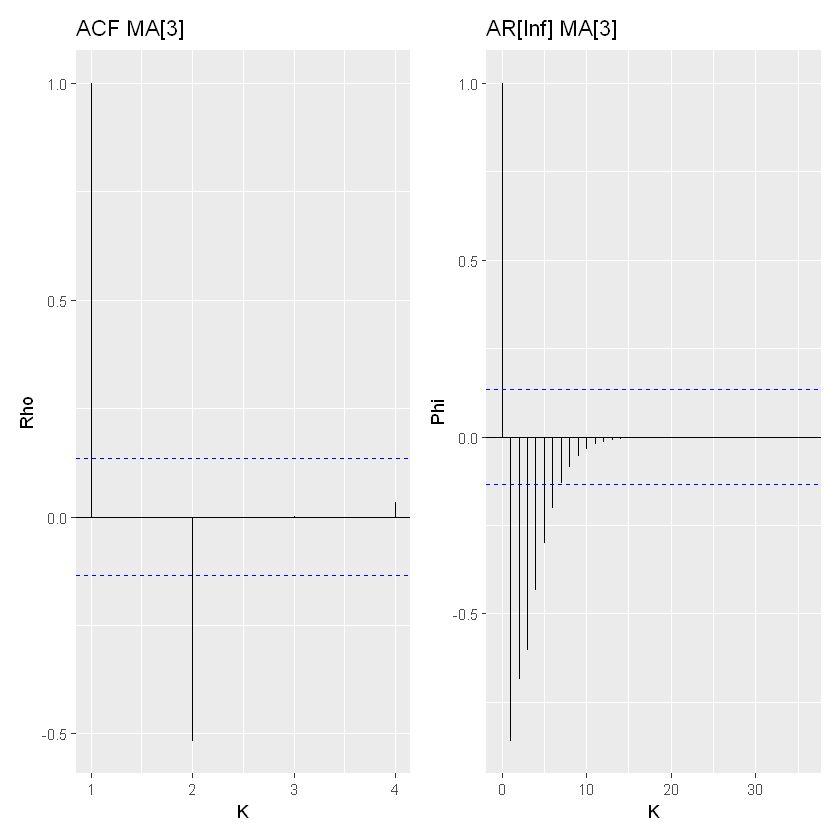

In [104]:
MA_3 = function(Phi, K, sigma_a, alpha = 0.05, MA_inf = FALSE){
    # Cálculo de los factores con su parte imaginaria
    Phi = matrix(data = c(-1, c(Phi)), nrow = 4, ncol = 1) * -1
    G = matrix(data = c(as.complex(polyroot(Phi)) ** -1), nrow = 3, ncol = 1)               # Polyroot devuelve las raices, ** -1 = Factores
    for (i in 1 : length(G)){
        if (sum(round(Im(G), 10)) == 0){
            G = G
        } else {
            Re_G = Re(G)
            Im_G = Im(G)
            for (i in 1 : length(G)){                                                               # Convierten los números complejos en reales
                G[i] = sqrt(Re_G[i] ** 2 + Im_G[i] ** 2)
            }
        }
    }

    # Identificación estacionareidad
    NG = length(G)
    G = round(Re(G), 10)
    Check = matrix(data = NA, nrow = NG, ncol = 1)
    for (i in 1 : NG){
        if (abs(G[i]) < 1){
            Check[i] = 1
        } else {
            Check[i] = 0
        }
    }

    # Identificación de factores iguales 
    Check_fact = matrix(data = sort(G, decreasing = TRUE), nrow = NG, ncol = 2)
    for (i in 2 : NG){
        Check_fact[1, 2] = 1
        if (Check_fact[i, 1] == Check_fact[(i - 1), 1]){                                      
            Check_fact[i, 2] = Check_fact[(i - 1), 2] + 1
        } else {                                                                    
            Check_fact[i, 2] = 1
        }
    }

    # Cálculo de los valores iniciales
    if (sum(Check) == 3){
        
        # Cálculo de los Rho
        Phi = Phi * -1
        Rho = matrix(data = NA, nrow = length(G), ncol = 1)
        Rho[1] = 1
        Rho[2] = (-Phi[2] + (Phi[2] * Phi[3]) + (Phi[3] * Phi[4])) / (1 + (Phi[2] ** 2) + (Phi[3] ** 2) + Phi[4] ** 2)
        Rho[3] = (-Phi[3] + (Phi[2] * Phi[4])) / (1 + (Phi[2] ** 2) + (Phi[3] ** 2) + Phi[4] ** 2)
        Rho[4] = (-Phi[4]) / (1 + (Phi[2] ** 2) + (Phi[3] ** 2) + Phi[4] ** 2)

        # Construcción ACF 
        ACF = data.frame(matrix(data = NA, nrow = K, ncol = 2))  
        ACF[, 1] = seq(1, 4, 1)
        colnames(ACF) = c('K', 'Rho')                            
        ACF[, 2] = Rho 
        ACF = with(ACF, data.frame(K, Rho))  

        # Matriz Pi
        Pi = matrix(data = c(1, -Phi[2], (-Phi[2] ** 2 - Phi[3])), ncol = 1, nrow = 3)

        # Cálculo de la ACF con y sin factores distintos
        if (sum(Check_fact[, 2]) == NG){
            Ginv = rbind(c(1, 1, 1), c(G), c(G ** 2))               # Cálculo de los valores iniciales con factores diferentes
            A = as.matrix(solve(Ginv) %*% Pi)
            print('Todos los factores son diferentes.')

            # Construcción ACF (Solución de la función generadora)
            PACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
            PACF[, 1] = seq(0, K, 1)
            colnames(PACF) = c('K', 'Phi')
            for (i in 0 : K){
                PACF[i + 1, 2] = as.numeric((A[1] * (G[1] ** i)) + (A[2] * (G[2] ** i)) + (A[3] * (G[3] ** i)))
            }
            PACF = with(PACF, data.frame(K, Phi))

        }
        if (sum(Check_fact[, 2]) == (NG + 1)){
            Ginv = rbind(c(1, 1, 0), c(G), c(G ** 2))               # Cálculo de los valores iniciales con factores iguales
            A = as.matrix(solve(Ginv) %*% Pi)
            print('Dos factores son iguales.')

            # Construcción ACF (Solución de la función generadora)
            PACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
            PACF[, 1] = seq(0, K, 1)
            colnames(PACF) = c('K', 'Pi')
            FG = matrix(data = NA, ncol = NG, nrow = (K + 1))
            for (j in 1 : NG){
                for (i in 0 : K){
                    if (Check_fact[j, 2] == 1){
                        FG[(i + 1), j] = A[j] * (G[j] ** i)
                    } else {
                        FG[(i + 1), j] = A[j] * (G[j] ** i) * i
                    }
                }
            }
            for (i in 0 : K){
                PACF[i + 1, 2] = as.numeric(sum(FG[(i + 1), ]))
            }
            PACF = with(PACF, data.frame(K, Rho))

        }
        if (sum(Check_fact[, 2]) == (NG + 3)){
            G_3 = c(G[1], (2 * G[2]), (4 * G[3]))
            Ginv = rbind(c(1, 0, 0), c(G), c(G_3 ** 2))              # Cálculo de los valores iniciales con factores iguales
            A = as.matrix(solve(Ginv) %*% Pi)
            print('Tres factores son iguales.')

            # Construcción ACF (Solución de la función generadora)
            PACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
            PACF[, 1] = seq(0, K, 1)
            colnames(PACF) = c('K', 'Rho')
            FG = matrix(data = NA, ncol = NG, nrow = (K + 1))
            for (j in 1 : NG){
                FG[(i + 1), j] = A[j] * (G[j] ** i) * i
            }
            for (i in 0 : K){
                PACF[i + 1, 2] = as.numeric(sum(FG[(i + 1), ]))
            }
            PACF = with(PACF, data.frame(K, Rho))

        }

        # Varianza del proceso (Gamma_0_1_2)
        Gamma_0 = (1 + Phi[2] ** 2 + Phi[3] ** 2 + Phi[4] ** 2)

        # Gráfica conjunta de ACF y PACF
        T = 216
        Cv = qt(p = (alpha / 2), df = (T - 1), lower.tail = FALSE) / sqrt(T)        # Valor crítico del intervalo de confianza
        G_ACF_3 <- ggplot(data = ACF, mapping = aes(x = K, y = Rho)) +
            labs(title = 'ACF MA[3]') +
            geom_hline(aes(yintercept = 0)) +
            geom_segment(mapping = aes(xend = K, yend = 0)) +
            geom_hline(aes(yintercept = Cv), color="blue",
                    linetype = "dashed") + 
            geom_hline(aes(yintercept = -Cv), color="blue",
                    linetype = "dashed")
                
        G_PACF_3 <- ggplot(data = PACF, mapping = aes(x = K, y = Phi)) +
            labs(title = 'AR[Inf] MA[3]') +
            geom_hline(aes(yintercept = 0)) +
            geom_segment(mapping = aes(xend = K, yend = 0)) + 
            geom_hline(aes(yintercept = Cv), color="blue",
                    linetype = "dashed") + 
            geom_hline(aes(yintercept = -Cv), color="blue",
                    linetype = "dashed")   


            # Salidas
            print(data.frame(G))
            print(data.frame(head(ACF, 4)))
            print(data.frame(head(PACF)))
            print(sprintf('La varianza del proceso es %s', round(Gamma_0, 4)))
            return(G_ACF_3 | G_PACF_3)
    } else {
        print(sprintf('El proceso no es invertible al tener sus factores |%s| > 1', round(G, 4)))
    }
}

MA_3(Phi = c(0.86, -0.0525, -0.0582), K = 36, sigma_a = 0.12, MA_inf = TRUE)

## ARMA[1, 1]

In [ ]:
ARMAacf(ar = 0.09, ma = 0.32)

[1] "La varianza del proceso es: 0.3654"
  K        Rho
1 0 1.0000e+00
2 1 9.0000e-02
3 2 8.1000e-03
4 3 7.2900e-04
5 4 6.5610e-05
6 5 5.9049e-06
  K           Phi
1 1 -0.0736000000
2 2 -0.0235520000
3 3 -0.0075366400
4 4 -0.0024117248
5 5 -0.0007717519
6 6 -0.0002469606


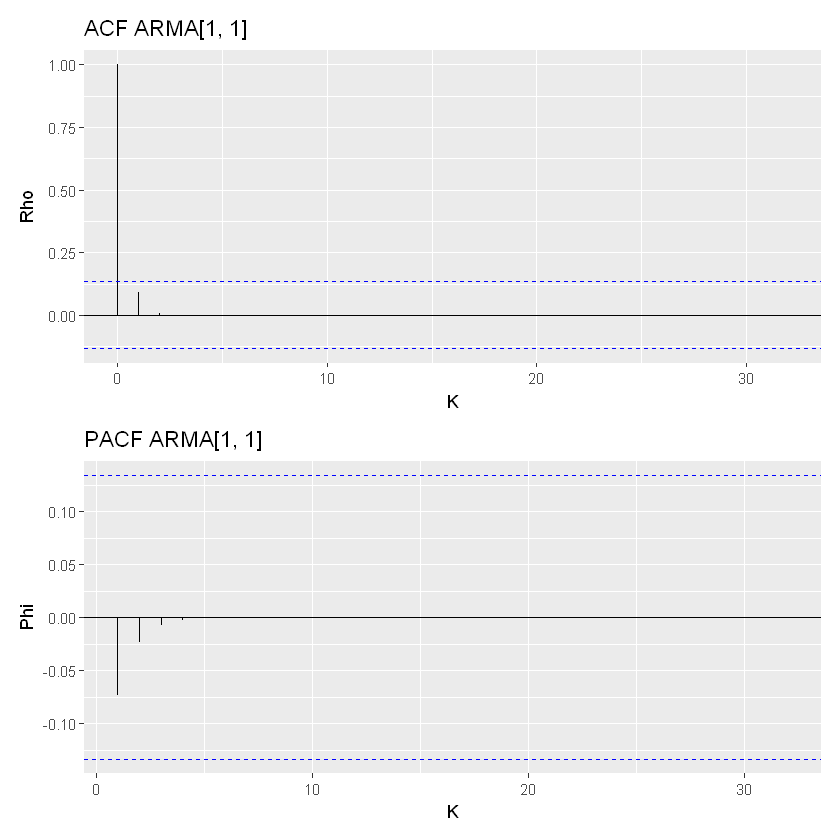

In [105]:
ARMA_11 = function(Phi, Theta, K, sigma_a, alpha = 0.05){
    if (abs(Phi) < 1){
        if (abs(Theta) < 1){
        # Varianza del proceso
        Gamma_0 = sigma_a * ((1 + (Theta ** 2) - (2 * Phi * Theta) - Theta) / (1 - (Phi ** 2)))

        # Construcción ACF
        ACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
        ACF[, 1] = seq(0, K, 1)
        colnames(ACF) = c('K', 'Rho')
        for (i in 0 : K){
            ACF[i + 1, 2] = Phi[1] ** i
        }
        ACF = with(ACF, data.frame(K, Rho))

        # Construcción PACF
        PACF = data.frame(matrix(data = NA, nrow = K, ncol = 2))
        PACF[, 1] = seq(1, K, 1)
        colnames(PACF) = c('K', 'Phi')
        for (i in 1 : K){
            PACF[i, 2] = (Phi - Theta) * (Theta ** i)
        }
        PACF = with(PACF, data.frame(K, Phi))


        # Gráficas conjuntas
        T = 216
        Cv = qt(p = (alpha / 2), df = (T - 1), lower.tail = FALSE) / sqrt(T)        # Valor crítico del intervalo de confianza
        G_ACF_1 <- ggplot(data = ACF, mapping = aes(x = K, y = Rho)) +
            labs(title = 'ACF ARMA[1, 1]') +
            geom_hline(aes(yintercept = 0)) +
            geom_segment(mapping = aes(xend = K, yend = 0)) +
            geom_hline(aes(yintercept = Cv), color="blue",
                    linetype = "dashed") + 
            geom_hline(aes(yintercept = -Cv), color="blue",
                    linetype = "dashed")
                
        G_PACF_1 <- ggplot(data = PACF, mapping = aes(x = K, y = Phi)) +
            labs(title = 'PACF ARMA[1, 1]') +
            geom_hline(aes(yintercept = 0)) +
            geom_segment(mapping = aes(xend = K, yend = 0)) + 
            geom_hline(aes(yintercept = Cv), color="blue",
                    linetype = "dashed") + 
            geom_hline(aes(yintercept = -Cv), color="blue",
                    linetype = "dashed")
        
        # Salidas
        print(sprintf('La varianza del proceso es: %s', round(Gamma_0, 4)))
        print(data.frame(head(ACF)))
        print(data.frame(head(PACF)))
        return(G_ACF_1 / G_PACF_1)

        } else {
            print(sprintf('El proceso no es invertible al tener su factor (Theta) |%s| > 1', round(Theta, 4)))
        }
    } else {
        print(sprintf('El proceso no es estacionario al tener su factor (Phi) |%s| > 1', round(Phi, 4)))
    }
} 

ARMA_11(Phi = c(0.09), Theta = c(0.32), K = 32, sigma_a = 0.5, alpha = 0.05)

## ARMA[2, 1]

           G
1  0.5054617
2 -0.4154617
     K       Gamma
[1,] 0 0.562374557
[2,] 1 0.007105962
[3,] 2 0.118738194
  K        Rho
1 0 1.00000000
2 1 0.01263564
3 2 0.21113721
4 3 0.02165583
5 4 0.04628784
6 5 0.00871363
  K           Pi
1 0  0.748095238
2 1 -0.230000000
3 2  0.136400000
4 3 -0.036024000
5 4  0.025401840
6 5 -0.005278874


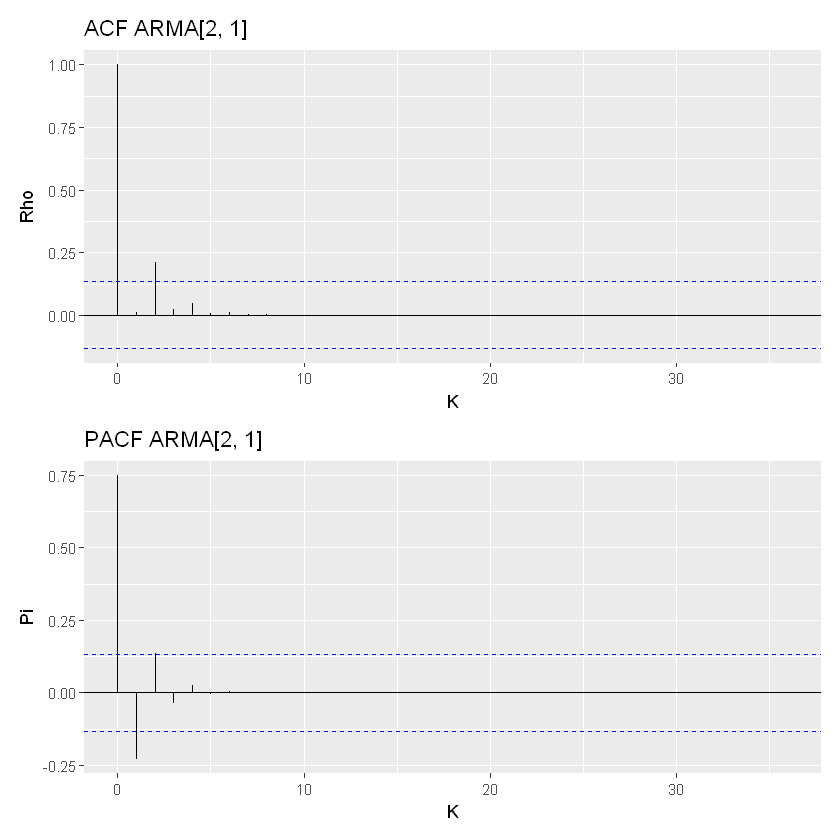

In [106]:
ARMA_21 = function(Phi, Theta, K, sigma_a, alpha = 0.05){
    # Cálculo de los factores con su parte imaginaria
    Phi = matrix(data = c(-1, c(Phi)), nrow = 3, ncol = 1) * -1
    G = matrix(data = c(as.complex(polyroot(Phi)) ** -1), nrow = 2, ncol = 1)               # Polyroot devuelve las raices, ** -1 = Factores
    for (i in 1 : length(G)){
        if (sum(round(Im(G), 10)) == 0){
            G = G
        } else {
            Re_G = Re(G)
            Im_G = Im(G)
            for (i in 1 : length(G)){                                                               # Convierten los números complejos en reales
                G[i] = sqrt(Re_G[i] ** 2 + Im_G[i] ** 2)
            }
        }
    }

    # Identificación estacionareidad
    G = round(Re(G), 10)
    Check = matrix(data = NA, nrow = length(G), ncol = 1)
    for (i in 1 : length(G)){
        if (abs(G[i]) < 1){
            Check[i] = 1
        } else {
            Check[i] = 0
        }
    }

    # Varianza del proceso
    Phi = Phi * -1
    Ga = matrix(data = rbind(c(1, -Phi[2], -Phi[3]), c(((-Phi[2]) / (1 - Phi[3])), 1, 0), c(-Phi[3], -Phi[2], 1)), nrow = 3, ncol = 3)
    Mma = matrix(data = cbind((sigma_a * (1 - (Phi[2] * Theta) + (Theta ** 2))), ((-Phi[2] * sigma_a) / (1 - Phi[3])), 0), ncol = 1, nrow = 3)
    Gamma = matrix(data = NA, nrow = 3, ncol = 2)
    colnames(Gamma) = c('K', 'Gamma')
    Gamma[, 1] = c(0, 1, 2)
    Gamma[, 2] = (solve(Ga) %*% Mma)

    if (sum(Check) == length(G)){
        if (abs(Theta) < 1){
            # Construcción ACF
            Rho = matrix(data = NA, nrow = (length(G)), ncol = 1)
            Rho[1] = Gamma[2, 2] / Gamma[1, 2]
            Rho[2] = Gamma[3, 2] / Gamma[1, 2]
            # Rho[1] = Gamma[1] / Gamma[1]

            # Identifiación de raices iguales
            if((G[1]) == (G[2])){                                           # Factores iguales
                FG = matrix(data = NA, nrow = 2, ncol = 2)
                FG = rbind(c(G), c((G[1] ** 2), (2 * G[2] ** 2)))                                   # Cálculo de los valores iniciales con factores iguales
                A = as.matrix(solve(FG) %*% Rho)

                # Construcción ACF (Solución de la función generadora)
                ACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
                ACF[, 1] = seq(0, K, 1)
                colnames(ACF) = c('K', 'Rho')
                for (i in 0 : K){
                    ACF[i + 1, 2] = as.numeric((A[1] * (G[1] ** i)) + (A[2] * (G[2] ** i) * i))
                }
                ACF = with(ACF, data.frame(K, Rho))
            } else{                                                         # Factores diferentes
                FG = matrix(data = NA, nrow = 2, ncol = 2)
                FG = rbind(c(G), c(G ** 2))                                   # Cálculo de los valores iniciales con factores iguales
                A = as.matrix(solve(FG) %*% Rho)
                
                # Construcción ACF (Solución de la función generadora)
                ACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
                ACF[, 1] = seq(0, K, 1)
                colnames(ACF) = c('K', 'Rho')
                for (i in 0 : K){
                    ACF[i + 1, 2] = as.numeric((A[1] * (G[1] ** i)) + (A[2] * (G[2] ** i)))
                }
                ACF = with(ACF, data.frame(K, Rho))
            }

            # Construcción PACF
            Pi = matrix(data = NA, nrow = 2, ncol = 1)
            Pi[1] = Phi[2] - Theta
            Pi[2] = Pi[1] * Theta + Phi[3]

            if((G[1]) == (G[2])){                                           # Factores iguales
                FG = matrix(data = NA, nrow = 2, ncol = 2)
                FG = rbind(c(G), c((G[1] ** 2), (2 * G[2] ** 2)))                                   # Cálculo de los valores iniciales con factores iguales
                A = as.matrix(solve(FG) %*% Pi)

                # Construcción ACF (Solución de la función generadora)
                PACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
                PACF[, 1] = seq(0, K, 1)
                colnames(PACF) = c('K', 'Pi')
                for (i in 0 : K){
                    PACF[i + 1, 2] = as.numeric((A[1] * (G[1] ** i)) + (A[2] * (G[2] ** i) * i))
                }
                PACF = with(PACF, data.frame(K, Pi))
            } else{                                                         # Factores diferentes
                FG = matrix(data = NA, nrow = 2, ncol = 2)
                FG = rbind(c(G), c(G ** 2))                                   # Cálculo de los valores iniciales con factores iguales
                A = as.matrix(solve(FG) %*% Pi)
                
                # Construcción ACF (Solución de la función generadora)
                PACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
                PACF[, 1] = seq(0, K, 1)
                colnames(PACF) = c('K', 'Pi')
                for (i in 0 : K){
                    PACF[i + 1, 2] = as.numeric((A[1] * (G[1] ** i)) + (A[2] * (G[2] ** i)))
                }
                PACF = with(PACF, data.frame(K, Pi))
            }

            # Gráficas conjuntas
            T = 216
            Cv = qt(p = (alpha / 2), df = (T - 1), lower.tail = FALSE) / sqrt(T)        # Valor crítico del intervalo de confianza
            G_ACF_2 <- ggplot(data = ACF, mapping = aes(x = K, y = Rho)) +
                labs(title = 'ACF ARMA[2, 1]') +
                geom_hline(aes(yintercept = 0)) +
                geom_segment(mapping = aes(xend = K, yend = 0)) +
                geom_hline(aes(yintercept = Cv), color="blue",
                        linetype = "dashed") + 
                geom_hline(aes(yintercept = -Cv), color="blue",
                        linetype = "dashed")
                    
            G_PACF_1 <- ggplot(data = PACF, mapping = aes(x = K, y = Pi)) +
                labs(title = 'PACF ARMA[2, 1]') +
                geom_hline(aes(yintercept = 0)) +
                geom_segment(mapping = aes(xend = K, yend = 0)) + 
                geom_hline(aes(yintercept = Cv), color="blue",
                        linetype = "dashed") + 
                geom_hline(aes(yintercept = -Cv), color="blue",
                        linetype = "dashed")
            
            # Salidas
            print(data.frame(G))
            print(Gamma)
            print(data.frame(head(ACF)))
            print(data.frame(head(PACF)))
            return(G_ACF_2 / G_PACF_1)

            } else {
                print(sprintf('El proceso no es invertible al tener su factor (Theta) |%s| > 1', round(G, 4)))
            }
        } else {
            print(sprintf('El proceso no es estacionario al tener su factor (Phi) |%s| > 1', round(Phi, 4)))
        }
}

ARMA_21(Phi = c(0.09, 0.21), Theta = c(0.32), K = 36, sigma_a = 0.5)

In [ ]:
ARMAacf(ar = c(0.09, 0.21), ma = c(0.32), pacf = TRUE)

## ARMA[1, 2]

           G
1  0.6288585
2 -0.5088585
  K       Gamma
1 0 -0.72846053
2 1 -0.01036145
3 2 -0.16093253
  K        Rho
1 0 1.0000e+00
2 1 9.0000e-02
3 2 8.1000e-03
4 3 7.2900e-04
5 4 6.5610e-05
6 5 5.9049e-06
  K         Pi
1 0 -1.0000000
2 1 -0.0300000
3 2 -0.3236000
4 3 -0.0484320
5 4 -0.1093638
6 5 -0.0286219


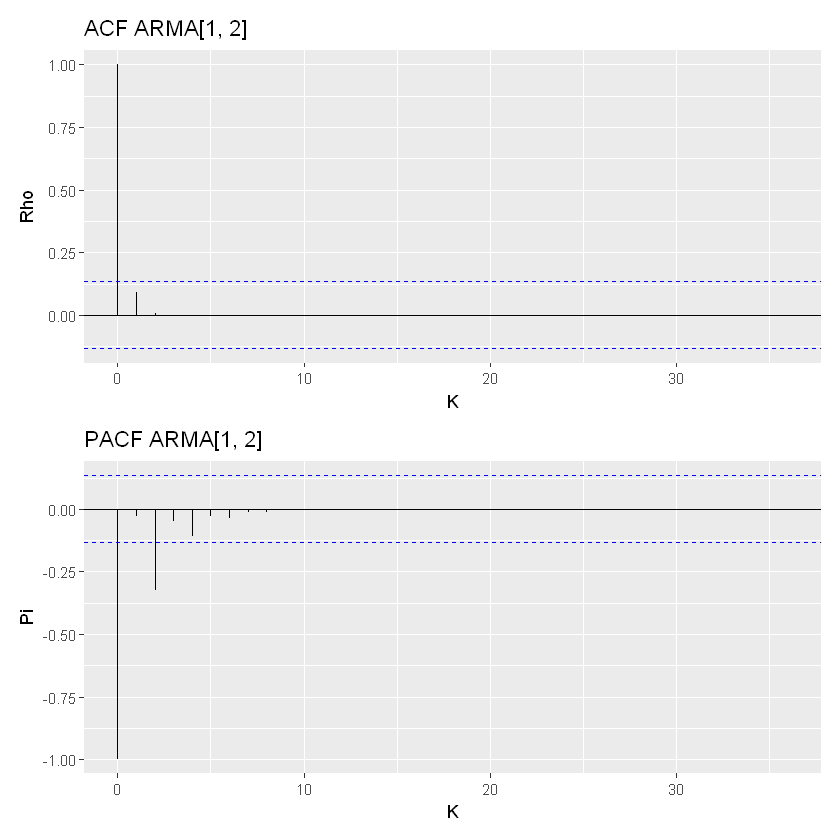

In [107]:
ARMA_12 = function(Phi, Theta, K, sigma_a, alpha = 0.05){
    # Cálculo de los factores con su parte imaginaria
    Theta = matrix(data = c(-1, c(Theta)), nrow = 3, ncol = 1) * -1
    G = matrix(data = c(as.complex(polyroot(Theta)) ** -1), nrow = 2, ncol = 1)               # Polyroot devuelve las raices, ** -1 = Factores
    for (i in 1 : length(G)){
        if (sum(round(Im(G), 10)) == 0){
            G = G
        } else {
            Re_G = Re(G)
            Im_G = Im(G)
            for (i in 1 : length(G)){                                                               # Convierten los números complejos en reales
                G[i] = sqrt(Re_G[i] ** 2 + Im_G[i] ** 2)
            }
        }
    }

    # Identificación estacionareidad
    G = round(Re(G), 10)
    Check = matrix(data = NA, nrow = length(G), ncol = 1)
    for (i in 1 : length(G)){
        if (abs(G[i]) < 1){
            Check[i] = 1
        } else {
            Check[i] = 0
        }
    }

    # Varianza del proceso
    Theta = Theta * -1
    Ga = matrix(data = rbind(c(1, -Phi, 0), c(-Phi, 1, 0), c(0, -Phi, 1)), nrow = 3, ncol = 3)
    Mma = matrix(data = cbind((-sigma_a * ((1 + (Theta[1] ** 2) - (Phi * Theta[2]) - (Theta[3] * (1 + (Theta[1] ** 2) - (Phi * Theta[2]) - Theta[3]))))), ((Theta[2] * sigma_a) - (-Theta[3] * sigma_a) * (Phi - Theta[2])), (-Theta[3] * sigma_a)), ncol = 1, nrow = 3)
    Gamma = matrix(data = NA, nrow = 3, ncol = 2)
    colnames(Gamma) = c('K', 'Gamma')
    Gamma[, 1] = c(0, 1, 2)
    Gamma[, 2] = (solve(Ga) %*% Mma)

    if (sum(Check) == length(G)){
        if (abs(Phi) < 1){

            # Construcción ACF
            ACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
            ACF[, 1] = seq(0, K, 1)
            colnames(ACF) = c('K', 'Rho')
            for (i in 0 : K){
                ACF[i + 1, 2] = Phi ** i
            }
            ACF = with(ACF, data.frame(K, Rho))

            # Construcción PACF
            Pi = matrix(data = NA, nrow = 2, ncol = 1)
            Pi[1] = Phi - Theta[2]
            Pi[2] = Pi[1] * Theta[2] - Theta[3]

            if((G[1]) == (G[2])){                                           # Factores iguales
                FG = matrix(data = NA, nrow = 2, ncol = 2)
                FG = rbind(c(G), c((G[1] ** 2), (2 * G[2] ** 2)))                                   # Cálculo de los valores iniciales con factores iguales
                A = as.matrix(solve(FG) %*% Pi)

                # Construcción ACF (Solución de la función generadora)
                PACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
                PACF[, 1] = seq(0, K, 1)
                colnames(PACF) = c('K', 'Pi')
                for (i in 0 : K){
                    PACF[i + 1, 2] = as.numeric((A[1] * (G[1] ** i)) + (A[2] * (G[2] ** i) * i))
                }
                PACF = with(PACF, data.frame(K, Pi))
            } else{                                                         # Factores diferentes
                FG = matrix(data = NA, nrow = 2, ncol = 2)
                FG = rbind(c(G), c(G ** 2))                                   # Cálculo de los valores iniciales con factores iguales
                A = as.matrix(solve(FG) %*% Pi)
                
                # Construcción ACF (Solución de la función generadora)
                PACF = data.frame(matrix(data = NA, nrow = (K + 1), ncol = 2))
                PACF[, 1] = seq(0, K, 1)
                colnames(PACF) = c('K', 'Pi')
                for (i in 0 : K){
                    PACF[i + 1, 2] = as.numeric((A[1] * (G[1] ** i)) + (A[2] * (G[2] ** i)))
                }
                PACF = with(PACF, data.frame(K, Pi))
            }

            # Gráficas conjuntas
            T = 216
            Cv = qt(p = (alpha / 2), df = (T - 1), lower.tail = FALSE) / sqrt(T)        # Valor crítico del intervalo de confianza
            G_ACF_1 <- ggplot(data = ACF, mapping = aes(x = K, y = Rho)) +
                labs(title = 'ACF ARMA[1, 2]') +
                geom_hline(aes(yintercept = 0)) +
                geom_segment(mapping = aes(xend = K, yend = 0)) +
                geom_hline(aes(yintercept = Cv), color="blue",
                        linetype = "dashed") + 
                geom_hline(aes(yintercept = -Cv), color="blue",
                        linetype = "dashed")
                    
            G_PACF_2 <- ggplot(data = PACF, mapping = aes(x = K, y = Pi)) +
                labs(title = 'PACF ARMA[1, 2]') +
                geom_hline(aes(yintercept = 0)) +
                geom_segment(mapping = aes(xend = K, yend = 0)) + 
                geom_hline(aes(yintercept = Cv), color="blue",
                        linetype = "dashed") + 
                geom_hline(aes(yintercept = -Cv), color="blue",
                        linetype = "dashed")
            
            # Salidas
            print(data.frame(G))
            print(data.frame(Gamma))
            print(data.frame(head(ACF)))
            print(data.frame(head(PACF)))
            return(G_ACF_1 / G_PACF_2)

            } else {
                print(sprintf('El proceso no es invertible al tener su factor (Theta) |%s| > 1', round(G, 4)))
            }
        } else {
            print(sprintf('El proceso no es estacionario al tener su factor (Phi) |%s| > 1', round(Phi, 4)))
        }
}

ARMA_12(Phi = c(0.09), Theta = c(0.12, 0.32), K = 36, sigma_a = 0.5)